## **Dynamic Pricing in E-hailing**

### **Importing Necessary Libraries**

In [1]:
#Loading Packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from pysal.model import spreg
import libpysal
import statsmodels.api as sm
import pysal as ps
from pysal.model import spreg
from pysal.lib import weights
import numpy as np

from scipy.spatial import distance
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.optim as optim
import random

### <b>Loading All Files <b>

In [2]:
#Loading the trip dataset
trip_data = pd.read_parquet('taxi/fhvhv_tripdata_2021-01.parquet',engine='pyarrow')
trip_data.convert_dtypes()
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11908468 entries, 0 to 11908467
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [3]:
# Drop rows where hvfhs_license_num is equal to HV0002, HV0004 and HV0005
trip_data = trip_data[~trip_data['hvfhs_license_num'].isin(['HV0002', 'HV0004','HV0005'])]
trip_data.info()
trip_data.shape

<class 'pandas.core.frame.DataFrame'>
Index: 8704128 entries, 0 to 11908467
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19  shar

(8704128, 24)

In [4]:
unique_dates = trip_data['pickup_datetime'].dt.date.unique()
print(unique_dates)

[datetime.date(2021, 1, 1) datetime.date(2021, 1, 2)
 datetime.date(2021, 1, 3) datetime.date(2021, 1, 4)
 datetime.date(2021, 1, 5) datetime.date(2021, 1, 6)
 datetime.date(2021, 1, 7) datetime.date(2021, 1, 8)
 datetime.date(2021, 1, 9) datetime.date(2021, 1, 10)
 datetime.date(2021, 1, 11) datetime.date(2021, 1, 12)
 datetime.date(2021, 1, 13) datetime.date(2021, 1, 14)
 datetime.date(2021, 1, 15) datetime.date(2021, 1, 16)
 datetime.date(2021, 1, 17) datetime.date(2021, 1, 18)
 datetime.date(2021, 1, 19) datetime.date(2021, 1, 20)
 datetime.date(2021, 1, 21) datetime.date(2021, 1, 22)
 datetime.date(2021, 1, 23) datetime.date(2021, 1, 24)
 datetime.date(2021, 1, 25) datetime.date(2021, 1, 26)
 datetime.date(2021, 1, 27) datetime.date(2021, 1, 28)
 datetime.date(2021, 1, 29) datetime.date(2021, 1, 30)
 datetime.date(2021, 1, 31)]


In [5]:
trip_data.head(-10)

hvfhs_license_num dispatching_base_num originating_base_num  \
0                   HV0003               B02682               B02682   
1                   HV0003               B02682               B02682   
2                   HV0003               B02764               B02764   
3                   HV0003               B02764               B02764   
4                   HV0003               B02764               B02764   
...                    ...                  ...                  ...   
11908449            HV0003               B02872               B02872   
11908452            HV0003               B02864               B02864   
11908453            HV0003               B02864               B02864   
11908456            HV0003               B02875               B02875   
11908457            HV0003               B02867               B02867   

            request_datetime   on_scene_datetime     pickup_datetime  \
0        2021-01-01 00:28:09 2021-01-01 00:31:42 2021-01-01 00:33:44   
1        2021-01-01 00:45:56 2021-01-01 00:55:19 2021-01-01 00:55:19   
2        2021-01-01 00:21:15 2021-01-01 00:22:41 2021-01-01 00:23:56   
3        2021-01-01 00:39:12 2021-01-01 00:42:37 2021-01-01 00:42:51   
4        2021-01-01 00:46:11 2021-01-01 00:47:17 2021-01-01 00:48:14   
...                      ...                 ...                 ...   
11908449 2021-01-31 23:35:18 2021-01-31 23:43:36 2021-01-31 23:45:37   
11908452 2021-01-31 23:07:47 2021-01-31 23:12:14 2021-01-31 23:14:07   
11908453 2021-01-31 23:42:47 2021-01-31 23:54:03 2021-01-31 23:54:25   
11908456 2021-01-31 23:17:35 2021-01-31 23:28:36 2021-01-31 23:29:09   
11908457 2021-01-31 22:49:59 2021-01-31 22:59:28 2021-01-31 23:01:07   

            dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
0        2021-01-01 00:49:07           230           166        5.26  ...   
1        2021-01-01 01:18:21           152           167        3.65  ...   
2        2021-01-01 00:38:05           233           142        3.51  ...   
3        2021-01-01 00:45:50           142           143        0.74  ...   
4        2021-01-01 01:08:42           143            78        9.20  ...   
...                      ...           ...           ...         ...  ...   
11908449 2021-01-31 23:58:43            33           195        1.64  ...   
11908452 2021-01-31 23:41:51           232           112        4.82  ...   
11908453 2021-02-01 00:11:21           255            65        4.39  ...   
11908456 2021-02-01 00:03:58           166            19       17.34  ...   
11908457 2021-01-31 23:33:11            71            22        5.09  ...   

          sales_tax  congestion_surcharge  airport_fee  tips  driver_pay  \
0              1.98                  2.75          NaN  0.00       14.99   
1              1.63                  0.00          NaN  0.00       17.06   
2              1.25                  2.75          NaN  0.94       12.98   
3              0.70                  2.75          NaN  0.00        7.41   
4              2.41                  2.75          NaN  0.00       22.44   
...             ...                   ...          ...   ...         ...   
11908449       1.54                  0.00          NaN  0.00       10.64   
11908452       2.00                  2.75          NaN  0.00       20.24   
11908453       1.59                  0.00          NaN  0.00       14.61   
11908456       6.46                  0.00          NaN  0.00       48.32   
11908457       3.21                  0.00          NaN  0.00       27.51   

          shared_request_flag  shared_match_flag  access_a_ride_flag  \
0                           N                  N                       
1                           N                  N                       
2                           N                  N                       
3                           N                  N                       
4                           N                  N                       
...      

In [6]:
#Loading geospatial data
taxi_zone_gdf = gpd.read_file('taxi/taxi_zones/taxi_zones.shp')
taxi_zone_gdf.info()
taxi_zone_gdf.head(10)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   
5         6    0.150491    0.000606  Arrochar/Fort Wadsworth           6   
6         7    0.107417    0.000390                  Astoria           7   
7         8    0.027591    0.000027             Astoria Park           8   
8         9    0.099784    0.000338               Auburndale           9   
9        10    0.099839    0.000436             Baisley Park          10   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...  
5  Staten Island  POLYGON ((966568.747 158679.855, 966615.256 15...  
6         Queens  POLYGON ((1010804.218 218919.641, 1011049.165 ...  
7         Queens  POLYGON ((1005482.276 221686.466, 1005304.898 ...  
8         Queens  POLYGON ((1043803.993 216615.925, 1043849.708 ...  
9         Queens  POLYGON ((1044355.072 190734.321, 1044612.122 ...

In [7]:
#Loading weather data
weather = pd.read_csv('taxi/nyc 2021-01-01 to 2021-12-31.csv')
weather = weather.convert_dtypes() # automatically and intelligently convert the data types of the DataFrame columns to the best possible types
weather.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              365 non-null    string 
 1   address           365 non-null    string 
 2   resolvedAddress   365 non-null    string 
 3   datetime          365 non-null    string 
 4   temp              365 non-null    Float64
 5   feelslike         365 non-null    Float64
 6   dew               365 non-null    Float64
 7   humidity          365 non-null    Float64
 8   precip            365 non-null    Float64
 9   precipprob        365 non-null    Int64  
 10  preciptype        152 non-null    string 
 11  snow              365 non-null    Float64
 12  snowdepth         365 non-null    Float64
 13  windgust          292 non-null    Float64
 14  windspeed         365 non-null    Float64
 15  winddir           365 non-null    Float64
 16  sealevelpressure  365 non-null    Float64
 1

In [8]:
weather_jan = weather[weather['datetime'].str.contains('2021-01')]
weather_jan.head(10)

name address              resolvedAddress    datetime  temp  feelslike  dew  \
0  nyc     nyc  New York, NY, United States  2021-01-01   2.5       -0.2 -3.0   
1  nyc     nyc  New York, NY, United States  2021-01-02   5.8        3.6  1.2   
2  nyc     nyc  New York, NY, United States  2021-01-03   2.5       -1.6 -0.5   
3  nyc     nyc  New York, NY, United States  2021-01-04   3.6        1.1 -0.2   
4  nyc     nyc  New York, NY, United States  2021-01-05   3.8        1.3 -1.5   
5  nyc     nyc  New York, NY, United States  2021-01-06   3.0       -0.6 -3.3   
6  nyc     nyc  New York, NY, United States  2021-01-07   1.9       -2.1 -6.4   
7  nyc     nyc  New York, NY, United States  2021-01-08   0.2       -3.7 -6.9   
8  nyc     nyc  New York, NY, United States  2021-01-09  -0.2       -4.6 -9.6   
9  nyc     nyc  New York, NY, United States  2021-01-10   1.5       -1.3 -7.8   

   humidity  precip  precipprob  ... snow  snowdepth  windgust  windspeed  \
0      67.8   15.33         100  ...  0.0        0.0      <NA>       15.5   
1      74.0    2.38         100  ...  1.9        0.6      54.6       25.5   
2      80.7    5.09         100  ...  1.2        1.7      42.2       24.1   
3      76.6    0.84         100  ...  0.5        0.7      <NA>       17.3   
4      68.7     0.0           0  ...  0.0        0.1      31.7       15.2   
5      63.7     0.0           0  ...  0.0        0.0      44.7       28.8   
6      54.9     0.0           0  ...  0.0        0.0      40.7       22.8   
7      59.2     0.0           0  ...  0.0        0.0      43.5       20.5   
8      49.9     0.0           0  ...  0.0        0.0      53.3       25.9   
9      50.5     0.0           0  ...  0.0        0.0      35.3       17.3   

   winddir  sealevelpressure  cloudcover  visibility  uvindex  severerisk  
0     69.8            1028.9        50.6        14.0        3        <NA>  
1    246.9            1012.4        63.9        12.2        5        <NA>  
2     66.4            1017.0        81.5        13.2        1        <NA>  
3    141.1            1014.6        89.3        15.6        4        <NA>  
4    124.4            1013.1        98.8        16.0        2        <NA>  
5    300.9            1015.0        46.6        16.0        5        <NA>  
6    322.7            1018.5         7.6        16.0        5        <NA>  
7    242.7            1015.3        25.7        16.0        3        <NA>  
8    264.4            1012.2        52.4        16.0        5        <NA>  
9    286.1            1021.8        16.5        16.0        4        <NA>  

[10 rows x 21 columns]

In [9]:
#Loading Zone description
zone_desc = pd.read_csv('taxi/taxi_zone_lookup.csv')
zone_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


## **Data Preparation**

### 1. Summary Statistics<br>
#### Continous Data

In [10]:
trip_data.describe().T

count                        mean  \
request_datetime        8704128  2021-01-17 03:36:07.395348   
on_scene_datetime       8704128  2021-01-17 03:39:25.354306   
pickup_datetime         8704128  2021-01-17 03:40:21.824002   
dropoff_datetime        8704128  2021-01-17 03:56:06.751314   
PULocationID          8704128.0                  135.392156   
DOLocationID          8704128.0                  138.609136   
trip_miles            8704128.0                    4.458284   
trip_time             8704128.0                  944.945969   
base_passenger_fare   8704128.0                   16.868765   
tolls                 8704128.0                    0.675572   
bcf                   8704128.0                    0.526835   
sales_tax             8704128.0                    1.466775   
congestion_surcharge  8704128.0                    0.849505   
airport_fee              5920.0                         0.0   
tips                  8704128.0                    0.432896   
driver_pay            8704128.0                   13.910998   

                                      min                  25%  \
request_datetime      2020-12-31 23:35:24  2021-01-09 13:02:13   
on_scene_datetime     2020-12-31 23:49:22  2021-01-09 13:05:05   
pickup_datetime       2021-01-01 00:00:00  2021-01-09 13:06:00   
dropoff_datetime      2021-01-01 00:02:42  2021-01-09 13:21:31   
PULocationID                          1.0                 70.0   
DOLocationID                          1.0                 72.0   
trip_miles                            0.0                 1.55   
trip_time                             1.0                516.0   
base_passenger_fare                -246.9                  8.7   
tolls                                 0.0                  0.0   
bcf                                   0.0                 0.26   
sales_tax                             0.0                 0.76   
congestion_surcharge                  0.0                  0.0   
airport_fee                           0.0                  0.0   
tips                                  0.0                  0.0   
driver_pay                         -11.65                 6.72   

                                             50%                         75%  \
request_datetime             2021-01-17 00:50:35         2021-01-24 19:23:06   
on_scene_datetime            2021-01-17 00:54:06         2021-01-24 19:26:18   
pickup_datetime       2021-01-17 00:55:09.500000         2021-01-24 19:27:23   
dropoff_datetime             2021-01-17 01:09:22  2021-01-24 19:42:13.250000   
PULocationID                               136.0                       210.0   
DOLocationID                               140.0                       213.0   
trip_miles                                  2.82                        5.52   
trip_time                                  796.0                      1207.0   
base_passenger_fare                        13.11                       20.62   
tolls                                        0.0                         0.0   
bcf                                         0.39                        0.64   
sales_tax                                   1.14                        1.82   
congestion_surcharge                         0.0                        2.75   
airport_fee                                  0.0                         0.0   
tips                                         0.0                         0.0   
driver_pay                                 10.66                       17.28   

                                      max         std  
request_datetime      2021-02-01 00:00:00         NaN  
on_scene_datetime     2021-01-31 23:59:44         NaN  
pickup_datetime       2021-01-31 23:59:58         NaN  
dropoff_datetime      2021-02-01 03:23:22         NaN  
PULocationID                        265.0    76.64533  
DOLocationID                        265.0   78.313779  
trip_miles                         738.95    4.900358  
trip_time             

In [11]:
taxi_zone_gdf.describe().T

count        mean        std       min        25%         50%  \
OBJECTID    263.0  132.000000  76.065761  1.000000  66.500000  132.000000   
Shape_Leng  263.0    0.094269   0.054594  0.014306   0.054722    0.084341   
Shape_Area  263.0    0.000402   0.000482  0.000006   0.000133    0.000268   
LocationID  263.0  131.984791  76.073787  1.000000  66.500000  132.000000   

                   75%         max  
OBJECTID    197.500000  263.000000  
Shape_Leng    0.119488    0.433470  
Shape_Area    0.000480    0.004866  
LocationID  197.500000  263.000000

In [12]:
weather_jan.describe().T

count         mean        std    min      25%     50%  \
temp               31.0     1.674194   3.249817   -6.2      0.0     1.9   
feelslike          31.0    -1.845161   4.528932  -14.1    -3.85    -0.8   
dew                31.0    -6.154839   5.151947  -17.2     -9.0    -5.3   
humidity           31.0    57.732258  12.277388   37.9    49.15    54.9   
precip             31.0     1.885806   4.825359    0.0      0.0     0.0   
precipprob         31.0    32.258065  47.519096    0.0      0.0     0.0   
snow               31.0     0.609677   1.816105    0.0      0.0     0.0   
snowdepth          31.0     0.474194   0.908467    0.0      0.0     0.0   
windgust           26.0    44.469231    9.16226   25.9     38.9   44.05   
windspeed          31.0    23.270968   7.354418    9.8    18.65    22.8   
winddir            31.0   216.403226  87.112355   53.1   141.15   246.9   
sealevelpressure   31.0  1015.606452    6.65492  998.1  1012.75  1015.7   
cloudcover         31.0    53.993548  26.495785    7.6     33.8    52.8   
visibility         31.0    14.990323   1.570638   10.8     14.2    16.0   
uvindex            31.0     3.774194   1.476701    1.0      2.5     4.0   
severerisk          0.0         <NA>       <NA>   <NA>     <NA>    <NA>   

                     75%     max  
temp                3.95     6.2  
feelslike            1.2     5.7  
dew                -3.15     2.1  
humidity            67.3    80.7  
precip             0.655   21.62  
precipprob         100.0   100.0  
snow                0.55    10.0  
snowdepth           0.65     4.3  
windgust          50.575    62.2  
windspeed          27.95    43.3  
winddir            285.6   322.7  
sealevelpressure  1019.5  1028.9  
cloudcover          74.8    98.8  
visibility          16.0    16.0  
uvindex              5.0     6.0  
severerisk          <NA>    <NA>

In [13]:
zone_desc.describe().T

count   mean        std  min   25%    50%    75%    max
LocationID  265.0  133.0  76.643112  1.0  67.0  133.0  199.0  265.0

#### Categorical Data

In [14]:
trip_data.describe(exclude='number').T

count unique     top     freq  \
hvfhs_license_num     8704128      1  HV0003  8704128   
dispatching_base_num  8704128     28  B02764  1009388   
originating_base_num  8698064     36  B02764  1008105   
request_datetime      8704128    NaN     NaN      NaN   
on_scene_datetime     8704128    NaN     NaN      NaN   
pickup_datetime       8704128    NaN     NaN      NaN   
dropoff_datetime      8704128    NaN     NaN      NaN   
shared_request_flag   8704128      1       N  8704128   
shared_match_flag     8704128      1       N  8704128   
access_a_ride_flag    8704128      1          8704128   
wav_request_flag      8704128      2       N  8690919   
wav_match_flag        8704128      2       N  8279174   

                                            mean                  min  \
hvfhs_license_num                            NaN                  NaN   
dispatching_base_num                         NaN                  NaN   
originating_base_num                         NaN                  NaN   
request_datetime      2021-01-17 03:36:07.395348  2020-12-31 23:35:24   
on_scene_datetime     2021-01-17 03:39:25.354306  2020-12-31 23:49:22   
pickup_datetime       2021-01-17 03:40:21.824002  2021-01-01 00:00:00   
dropoff_datetime      2021-01-17 03:56:06.751314  2021-01-01 00:02:42   
shared_request_flag                          NaN                  NaN   
shared_match_flag                            NaN                  NaN   
access_a_ride_flag                           NaN                  NaN   
wav_request_flag                             NaN                  NaN   
wav_match_flag                               NaN                  NaN   

                                      25%                         50%  \
hvfhs_license_num                     NaN                         NaN   
dispatching_base_num                  NaN                         NaN   
originating_base_num                  NaN                         NaN   
request_datetime      2021-01-09 13:02:13         2021-01-17 00:50:35   
on_scene_datetime     2021-01-09 13:05:05         2021-01-17 00:54:06   
pickup_datetime       2021-01-09 13:06:00  2021-01-17 00:55:09.500000   
dropoff_datetime      2021-01-09 13:21:31         2021-01-17 01:09:22   
shared_request_flag                   NaN                         NaN   
shared_match_flag                     NaN                         NaN   
access_a_ride_flag                    NaN                         NaN   
wav_request_flag                      NaN                         NaN   
wav_match_flag                        NaN                         NaN   

                                             75%                  max  
hvfhs_license_num                            NaN                  NaN  
dispatching_base_num                         NaN                  NaN  
originating_base_num                         NaN                  NaN  
request_datetime             2021-01-24 19:23:06  2021-02-01 00:00:00  
on_scene_datetime            2021-01-24 19:26:18  2021-01-31 23:59:44  
pickup_datetime              2021-01-24 19:27:23  2021-01-31 23:59:58  
dropoff_datetime      2021-01-24 19:42:13.250000  2021-02-01 03:23:22  
shared_request_flag                          NaN                  NaN  
shared_match_flag                            NaN                  NaN  
access_a_ride_flag                           NaN                  NaN  
wav_request_flag                             NaN                  NaN  
wav_match_flag                               NaN                  NaN

In [15]:
weather_jan.describe(exclude='number').T

count unique                          top freq
name               31      1                          nyc   31
address            31      1                          nyc   31
resolvedAddress    31      1  New York, NY, United States   31
datetime           31     31                   2021-01-01    1
preciptype         10      3                    rain,snow    5

In [16]:
zone_desc.describe(exclude='number').T

count unique                                            top freq
Borough        265      7                                         Queens   69
Zone           264    261  Governor's Island/Ellis Island/Liberty Island    3
service_zone   263      4                                      Boro Zone  205

### 2. Checking Missing Values

In [17]:
# Missing value in each col
trip_data.isnull().sum()

hvfhs_license_num             0
dispatching_base_num          0
originating_base_num       6064
request_datetime              0
on_scene_datetime             0
pickup_datetime               0
dropoff_datetime              0
PULocationID                  0
DOLocationID                  0
trip_miles                    0
trip_time                     0
base_passenger_fare           0
tolls                         0
bcf                           0
sales_tax                     0
congestion_surcharge          0
airport_fee             8698208
tips                          0
driver_pay                    0
shared_request_flag           0
shared_match_flag             0
access_a_ride_flag            0
wav_request_flag              0
wav_match_flag                0
dtype: int64

In [18]:
trip_data_cp = trip_data
trip_data_cp

hvfhs_license_num dispatching_base_num originating_base_num  \
0                   HV0003               B02682               B02682   
1                   HV0003               B02682               B02682   
2                   HV0003               B02764               B02764   
3                   HV0003               B02764               B02764   
4                   HV0003               B02764               B02764   
...                    ...                  ...                  ...   
11908463            HV0003               B02765               B02765   
11908464            HV0003               B02872               B02872   
11908465            HV0003               B02872               B02872   
11908466            HV0003               B02764               B02764   
11908467            HV0003               B02764               B02764   

            request_datetime   on_scene_datetime     pickup_datetime  \
0        2021-01-01 00:28:09 2021-01-01 00:31:42 2021-01-01 00:33:44   
1        2021-01-01 00:45:56 2021-01-01 00:55:19 2021-01-01 00:55:19   
2        2021-01-01 00:21:15 2021-01-01 00:22:41 2021-01-01 00:23:56   
3        2021-01-01 00:39:12 2021-01-01 00:42:37 2021-01-01 00:42:51   
4        2021-01-01 00:46:11 2021-01-01 00:47:17 2021-01-01 00:48:14   
...                      ...                 ...                 ...   
11908463 2021-01-31 23:13:51 2021-01-31 23:25:03 2021-01-31 23:25:40   
11908464 2021-01-31 23:23:56 2021-01-31 23:29:03 2021-01-31 23:29:31   
11908465 2021-01-31 23:42:53 2021-01-31 23:49:23 2021-01-31 23:49:32   
11908466 2021-01-31 23:04:32 2021-01-31 23:09:13 2021-01-31 23:09:29   
11908467 2021-01-31 23:22:20 2021-01-31 23:28:33 2021-01-31 23:28:33   

            dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
0        2021-01-01 00:49:07           230           166        5.26  ...   
1        2021-01-01 01:18:21           152           167        3.65  ...   
2        2021-01-01 00:38:05           233           142        3.51  ...   
3        2021-01-01 00:45:50           142           143        0.74  ...   
4        2021-01-01 01:08:42           143            78        9.20  ...   
...                      ...           ...           ...         ...  ...   
11908463 2021-01-31 23:40:10            89            71        2.29  ...   
11908464 2021-01-31 23:47:44           182           167        4.10  ...   
11908465 2021-02-01 00:04:36           167           169        2.40  ...   
11908466 2021-01-31 23:27:46           188            37        3.60  ...   
11908467 2021-01-31 23:56:36            37             4        5.76  ...   

          sales_tax  congestion_surcharge  airport_fee  tips  driver_pay  \
0              1.98                  2.75          NaN  0.00       14.99   
1              1.63                  0.00          NaN  0.00       17.06   
2              1.25                  2.75          NaN  0.94       12.98   
3              0.70                  2.75          NaN  0.00        7.41   
4              2.41                  2.75          NaN  0.00       22.44   
...             ...                   ...          ...   ...         ...   
11908463       1.49                  0.00          NaN  0.00       12.06   
11908464       1.53                  0.00          NaN  2.00       13.66   
11908465       1.73                  0.00          NaN  0.00       15.53   
11908466       1.76                  0.00          NaN  0.00       17.36   
11908467       3.14                  2.75          NaN  0.00       21.69   

          shared_request_flag  shared_match_flag  access_a_ride_flag  \
0                           N                  N                       
1                           N                  N                       
2                           N                  N                       
3                           N                  N                       
4                           N                  N                       
...      

In [19]:
weather_jan.isnull().sum()

name                 0
address              0
resolvedAddress      0
datetime             0
temp                 0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
preciptype          21
snow                 0
snowdepth            0
windgust             5
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
uvindex              0
severerisk          31
dtype: int64

In [20]:
zone_desc.isnull().sum()

LocationID      0
Borough         0
Zone            1
service_zone    2
dtype: int64

### 3. Data Cleaning

In [21]:
print(trip_data.columns)

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')


In [22]:
trip_data = trip_data.drop(columns=['originating_base_num','on_scene_datetime','airport_fee'])

In [23]:
trip_data = trip_data.dropna()

Because snow has no precipitation type, there are null values, so we replace them by defining a threshold for the snow column, i.e. if the value is larger than 0.5, it is rainy, else it is sunny.

In [24]:
weather_jan.loc[(weather_jan['preciptype'].isnull()) & (weather_jan['snow'] < 0.5), 'preciptype'] = 'sunny'
weather_jan['preciptype'].fillna('rain', inplace= True)

C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\3571109904.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_jan['preciptype'].fillna('rain', inplace= True)
C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\3571109904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_jan['preciptype'].fillna('rain', inplace= True)


In [25]:
# Drop column Severerisk
weather_new = weather_jan.drop(columns=['severerisk'])

In [26]:
# Replacing missing values with unknown
zone_desc['service_zone'].fillna('unknown', inplace = True)
zone_desc['Zone'].fillna('unknown', inplace = True)

C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\1953006241.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  zone_desc['service_zone'].fillna('unknown', inplace = True)
C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\1953006241.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

## <b>Visualization

### 1. Exploratory Data Analysis

In [27]:
# Creating 2 new dataframe with the columns of pickup_datetime and dropoff_datetime
pickup_datetime = pd.to_datetime(trip_data['pickup_datetime'])
dropoff_datetime = pd.to_datetime(trip_data['dropoff_datetime'])
pickup_datetime = pickup_datetime.dt.hour
dropoff_datetime = dropoff_datetime.dt.hour

In [28]:
# Assuming pickup_datetime and dropoff_datetime are pandas Series with datetime values
def categorize_time(hour):
    if 7 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 19:
        return 'afternoon'
    elif 20 <= hour <= 23 or 0 <= hour <= 1:
        return 'evening'
    else:
        return 'night'

# Apply the function to the 'hour' component of the datetime
pickup_time_cat = pickup_datetime.apply(categorize_time)
dropoff_time_cat = dropoff_datetime.apply(categorize_time)


In [29]:
# Split the pickup_datetime and dropoff_datetime with moring(7-11), afternoon(12-19), evening(19-1) and night(1-7)
# pickup_datetime = pickup_datetime.replace([7, 8, 9, 10, 11], 'morning')
# pickup_datetime = pickup_datetime.replace([12, 13, 14, 15, 16, 17, 18, 19], 'afternoon')
# pickup_datetime = pickup_datetime.replace([20, 21, 22, 23, 0, 1], 'evening')
# pickup_datetime = pickup_datetime.replace([2, 3, 4, 5, 6], 'night')
# dropoff_datetime = dropoff_datetime.replace([7, 8, 9, 10, 11], 'morning')
# dropoff_datetime = dropoff_datetime.replace([12, 13, 14, 15, 16, 17, 18, 19], 'afternoon')
# dropoff_datetime = dropoff_datetime.replace([20, 21, 22, 23, 0, 1], 'evening')
# dropoff_datetime = dropoff_datetime.replace([2, 3, 4, 5, 6], 'night')

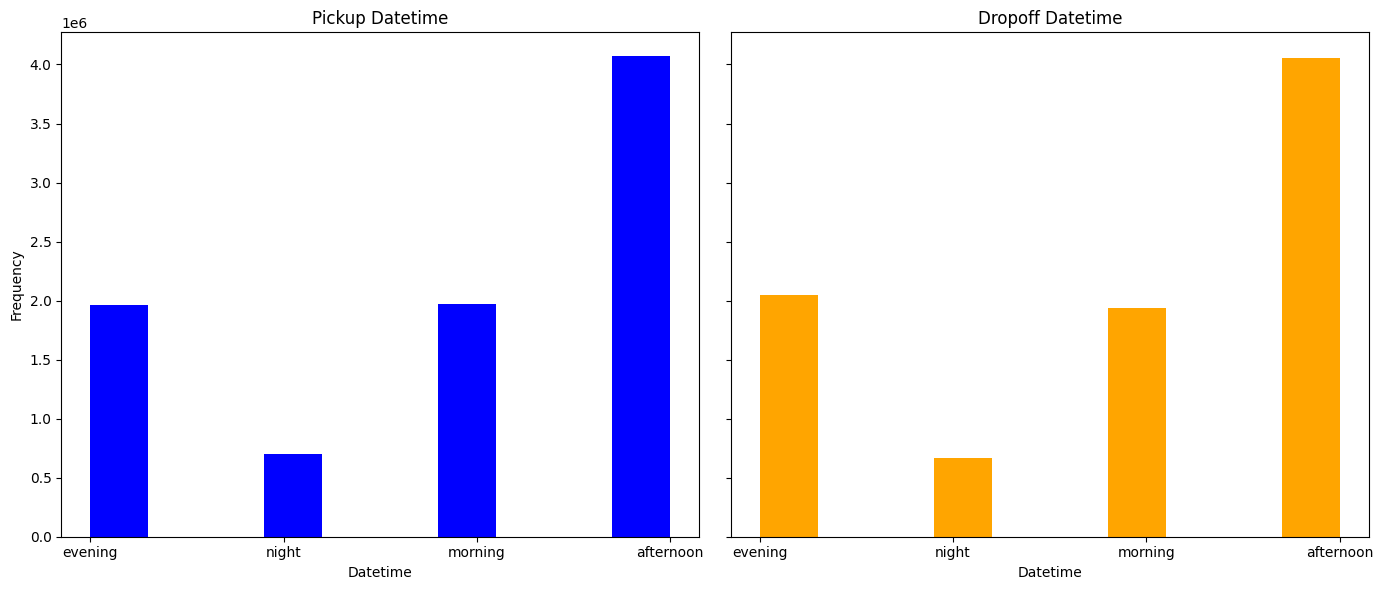

In [30]:
# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot the histogram for pickup_datetime on the first subplot
axs[0].hist(pickup_time_cat, color='blue', bins=10)
axs[0].set_title('Pickup Datetime')
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Frequency')

# Plot the histogram for dropoff_datetime on the second subplot
axs[1].hist(dropoff_time_cat, color='orange', bins=10)
axs[1].set_title('Dropoff Datetime')
axs[1].set_xlabel('Datetime')

# Show the plot
plt.tight_layout()  # Adjusts the spacing between the plots
plt.show()


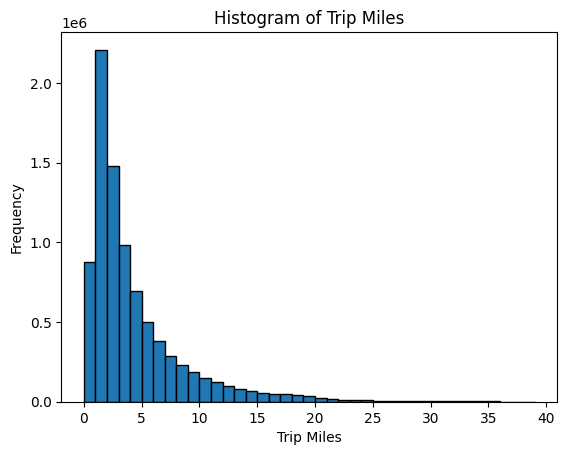

In [31]:
plt.hist(trip_data['trip_miles'],bins=range(0,40,1),edgecolor='black')
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Miles')
plt.show()

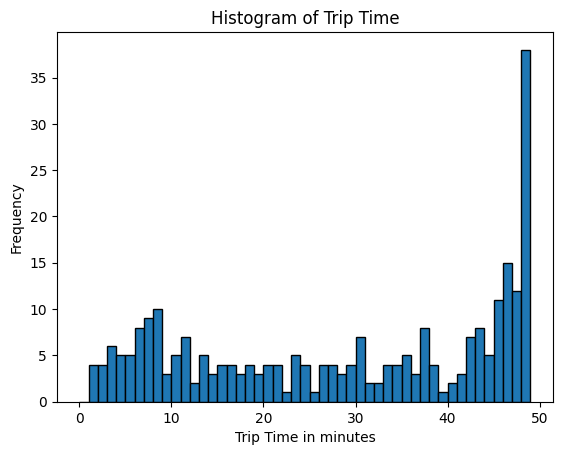

In [32]:
plt.hist(trip_data['trip_time'],bins=range(0,50,1),edgecolor='black')
plt.xlabel('Trip Time in minutes')
plt.ylabel('Frequency')
plt.title('Histogram of Trip Time')
plt.show()

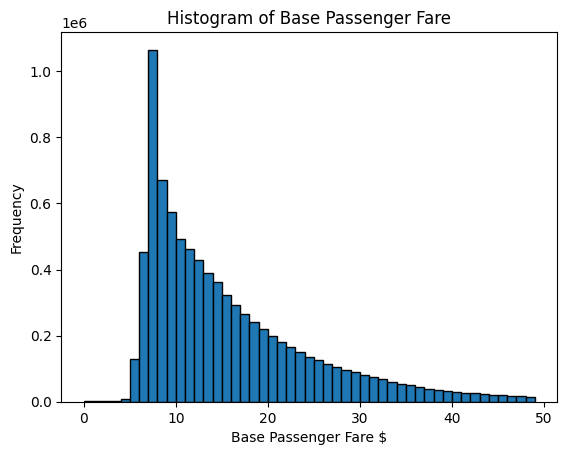

In [33]:
plt.hist(trip_data['base_passenger_fare'],bins=range(0,50,1),edgecolor='black')
plt.xlabel('Base Passenger Fare $')
plt.ylabel('Frequency')
plt.title('Histogram of Base Passenger Fare')
plt.show()

Text(0, 0.5, 'Temperature')

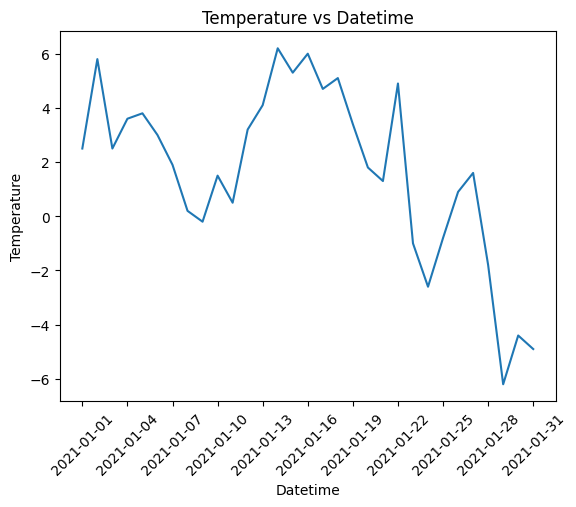

In [34]:
# Plotting temp with datetime
plt.plot(weather_jan['datetime'], weather_jan['temp'])
plt.xticks(weather_jan['datetime'][::3],rotation=45)
plt.title('Temperature vs Datetime')
plt.xlabel('Datetime')
plt.ylabel('Temperature')

Text(0, 0.5, 'Snow in cm')

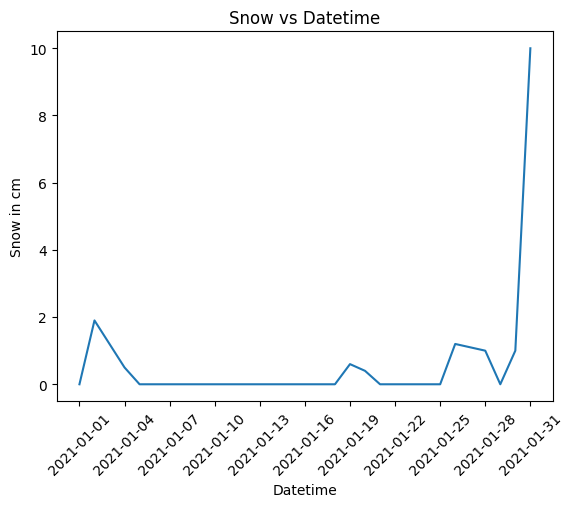

In [35]:
# PLotting snow with datetime
plt.plot(weather_jan['datetime'], weather_jan['snow'])
plt.xticks(weather_jan['datetime'][::3],rotation=45)
plt.title('Snow vs Datetime')
plt.xlabel('Datetime')
plt.ylabel('Snow in cm')

We can observe that as the temperature decreases around the end of the month the snowfall in cm increases.

Text(0, 0.5, 'Windspeed in Km/h')

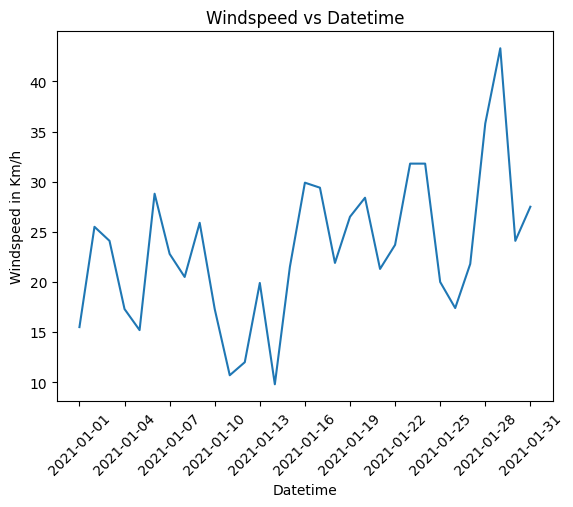

In [36]:
plt.plot(weather_jan['datetime'], weather_jan['windspeed'])
plt.xticks(weather_jan['datetime'][::3],rotation=45)
plt.title('Windspeed vs Datetime')
plt.xlabel('Datetime')
plt.ylabel('Windspeed in Km/h')

### 2. Exploratory Spatial Data Analysis

#### 1. Exploring Taxi Zones

<Axes: >

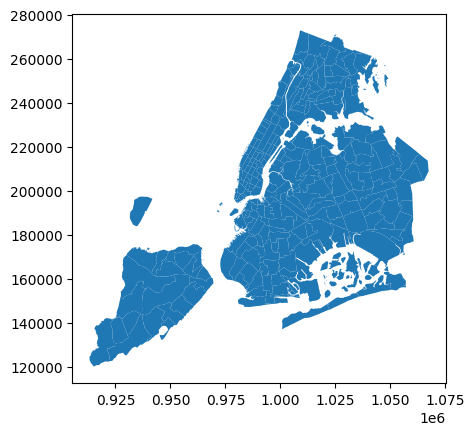

In [37]:
# Plotting taxi zones
taxi_zone_gdf.plot()

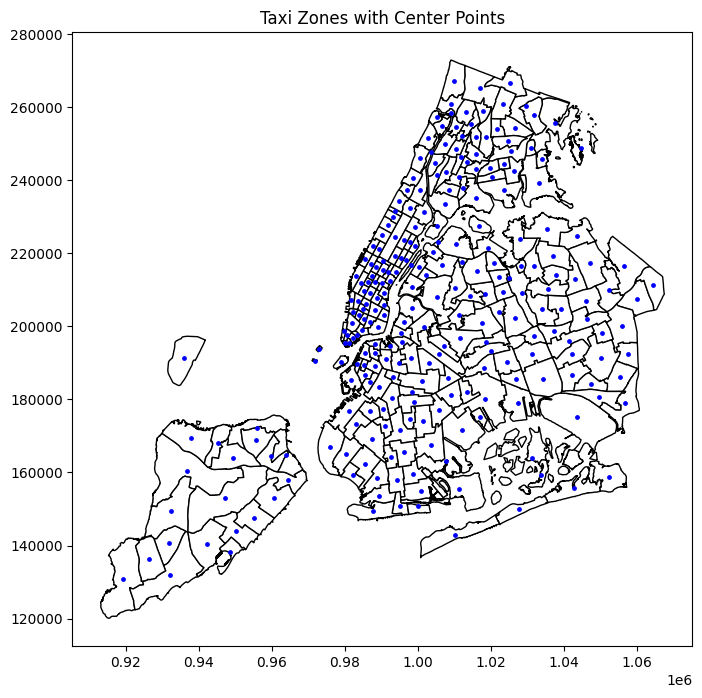

In [38]:
#Getting the center of the taxi zone
taxi_zone_gdf['center'] = taxi_zone_gdf.centroid

#plotting center of zones
fig, ax = plt.subplots(figsize=(8, 8))
taxi_zone_gdf.plot(ax=ax, color='white', edgecolor='black')
taxi_zone_gdf['center'].plot(ax=ax, color='blue', markersize=6)
ax.set_title('Taxi Zones with Center Points')
plt.show()

In [39]:
#Average trip distance and trip time
avg_trip_distance = trip_data['trip_miles'].mean()
avg_trip_time = trip_data['trip_time'].mean()
print(f"Average Trip Distance: {avg_trip_distance} miles")
print(f"Average Trip Time: {avg_trip_time} minutes")

Average Trip Distance: 4.458284280745876 miles
Average Trip Time: 944.9459686254614 minutes


#### 2. No.of Trip per region

In [40]:
# Merging the trip data with taxi-zone
cols_to_merge = ['PULocationID']
merge_data = trip_data[cols_to_merge].merge(taxi_zone_gdf, left_on='PULocationID', right_on='LocationID')

# No.of trips per zone
pickup_counts = merge_data['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID','pickup_count']

# merge pickup_count and taxi_zone_gdf
taxi_zone_gdf = taxi_zone_gdf.merge(pickup_counts, on="LocationID", how="left")
taxi_zone_gdf['pickup_count'].fillna(0, inplace=True)

# Convert the pickup_count to float
taxi_zone_gdf['pickup_count'] = taxi_zone_gdf['pickup_count'].astype(float)

C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\4060094587.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  taxi_zone_gdf['pickup_count'].fillna(0, inplace=True)


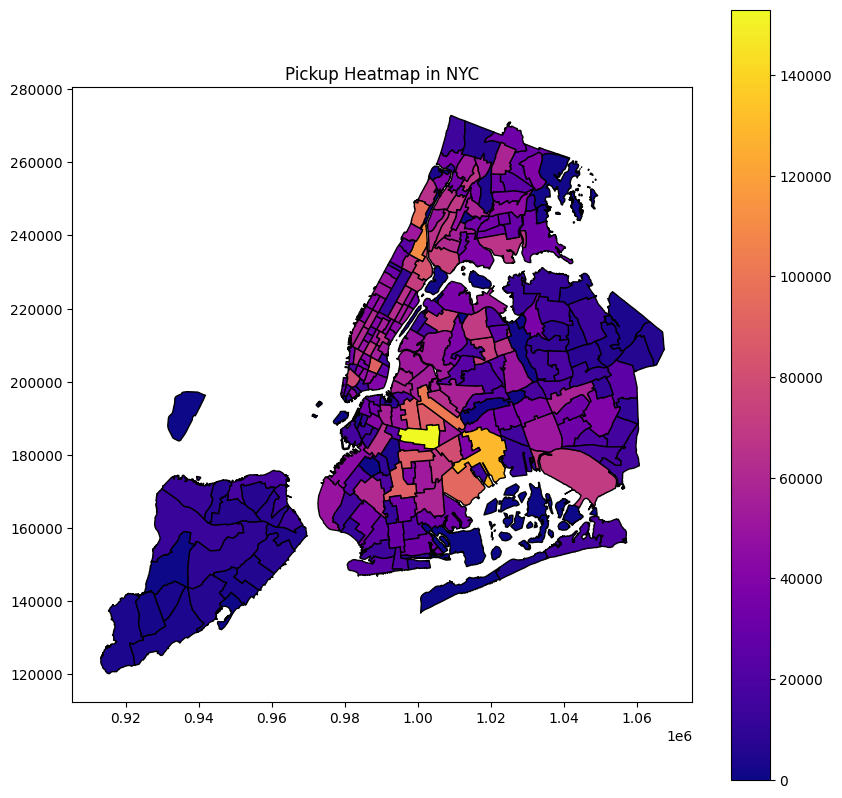

In [41]:
# Plot the pickup_count
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zone_gdf.plot(ax=ax, column="pickup_count", legend=True, cmap="plasma", edgecolor="black")
ax.set_title("Pickup Heatmap in NYC")
plt.show()

In [42]:
# Group by LocationID and count the number of pickups
pickup_counts = trip_data.groupby('PULocationID')['PULocationID'].count()

# Sort the pickup counts in descending order
top_5_pickup_locations = pickup_counts.sort_values(ascending=False).head(5)

# Print the top 5 locations with their pickup counts
print("Top 5 Pickup Locations with Counts:")
print(top_5_pickup_locations)


Top 5 Pickup Locations with Counts:
PULocationID
61     153016
76     129396
42     111364
37     102434
244     97212
Name: PULocationID, dtype: int64


#### 3. Exploring the weather on Spatial Data

In [43]:
# Converting the pickup and weather datetime to date
trip_data['pickup_date'] = pd.to_datetime(trip_data['pickup_datetime']).dt.date
weather_jan['date'] = pd.to_datetime(weather_jan['datetime']).dt.date

C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\1775372472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_jan['date'] = pd.to_datetime(weather_jan['datetime']).dt.date


In [44]:
weather_jan.head()
#trip_data.head()

name address              resolvedAddress    datetime  temp  feelslike  dew  \
0  nyc     nyc  New York, NY, United States  2021-01-01   2.5       -0.2 -3.0   
1  nyc     nyc  New York, NY, United States  2021-01-02   5.8        3.6  1.2   
2  nyc     nyc  New York, NY, United States  2021-01-03   2.5       -1.6 -0.5   
3  nyc     nyc  New York, NY, United States  2021-01-04   3.6        1.1 -0.2   
4  nyc     nyc  New York, NY, United States  2021-01-05   3.8        1.3 -1.5   

   humidity  precip  precipprob  ... snowdepth  windgust  windspeed  winddir  \
0      67.8   15.33         100  ...       0.0      <NA>       15.5     69.8   
1      74.0    2.38         100  ...       0.6      54.6       25.5    246.9   
2      80.7    5.09         100  ...       1.7      42.2       24.1     66.4   
3      76.6    0.84         100  ...       0.7      <NA>       17.3    141.1   
4      68.7     0.0           0  ...       0.1      31.7       15.2    124.4   

   sealevelpressure  cloudcover  visibility  uvindex  severerisk        date  
0            1028.9        50.6        14.0        3        <NA>  2021-01-01  
1            1012.4        63.9        12.2        5        <NA>  2021-01-02  
2            1017.0        81.5        13.2        1        <NA>  2021-01-03  
3            1014.6        89.3        15.6        4        <NA>  2021-01-04  
4            1013.1        98.8        16.0        2        <NA>  2021-01-05  

[5 rows x 22 columns]

In [45]:
# Merging the dataset
merged_data = trip_data.merge(weather_jan, left_on='pickup_date', right_on='date')

#Getting Temp greater than 0`C
greater_zero_temp = merged_data[merged_data['temp'] > 0]

# pickup count for temperature greater than 0
greater_zero_temp_counts = greater_zero_temp['PULocationID'].value_counts().reset_index()
greater_zero_temp_counts.columns = ['LocationID','pickup_greater_zero']

# Merging counts with taxi-zones
taxi_zone_gdf_greater_zero = taxi_zone_gdf.merge(greater_zero_temp_counts, on="LocationID", how="left")
taxi_zone_gdf_greater_zero['pickup_greater_zero'] = taxi_zone_gdf_greater_zero['pickup_greater_zero'].astype(float)

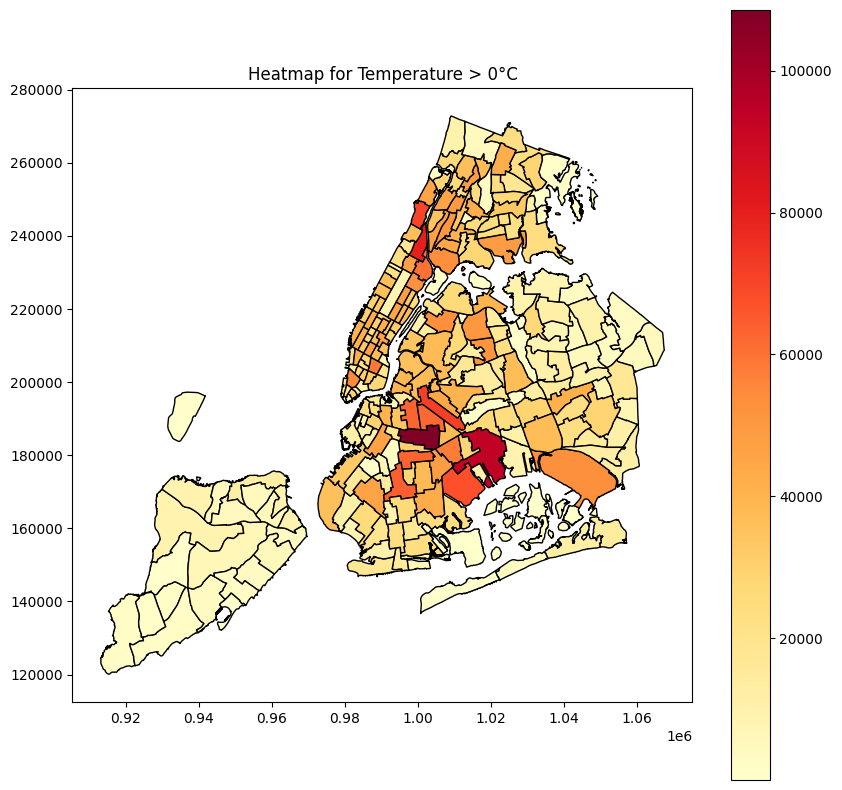

In [46]:
# Plot the map for Temperature > 0`C
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zone_gdf_greater_zero.plot(ax=ax, column="pickup_greater_zero", legend=True, cmap="YlOrRd", edgecolor="black")
ax.set_title("Heatmap for Temperature > 0°C")
plt.show()

In [47]:
# Filter the data set for snow > 0.5
snow = merged_data[merged_data['snow'] > 0.5]

# Calculate pickup counts for locations with snow
snow_counts = snow["PULocationID"].value_counts().reset_index()
snow_counts.columns = ["LocationID", "snow_count"]

# Merge the counts with the taxi_zone_gdf
taxi_zone_gdf_snow = taxi_zone_gdf.merge(snow_counts, on="LocationID", how="left")

# Ensure there are no NaN values in the snow_count column, fill with 0 if needed
taxi_zone_gdf_snow["snow_count"] = taxi_zone_gdf_snow["snow_count"].fillna(0).astype(float)


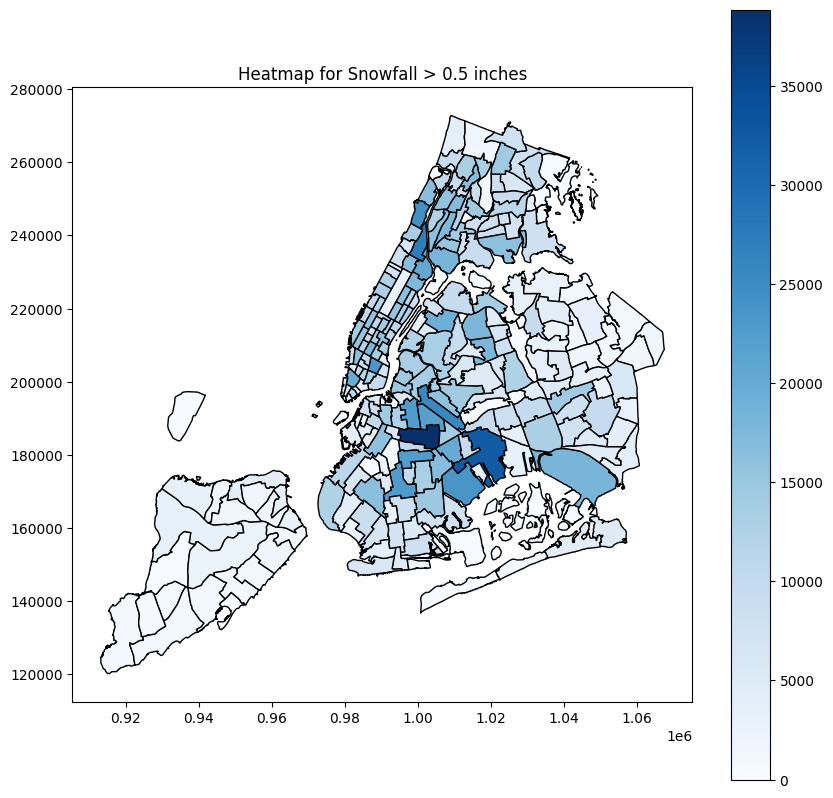

In [48]:
# Plot the map for Snow > 0.5
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zone_gdf_snow.plot(ax=ax, column="snow_count", legend=True, cmap="Blues", edgecolor="black")
ax.set_title("Heatmap for Snowfall > 0.5 inches")
plt.show()


In [49]:
# Filter the dataset for snow <= 0.5
not_snow = merged_data[merged_data['snow'] <= 0.5]

# Calculate pickup counts for locations with snow <= 0.5
not_snow_counts = not_snow["PULocationID"].value_counts().reset_index()
not_snow_counts.columns = ["LocationID", "not_snow_count"]

# Merge the counts with the taxi_zone_gdf
taxi_zone_gdf_not_snow = taxi_zone_gdf.merge(not_snow_counts, on="LocationID", how="left")

# Ensure there are no NaN values in the not_snow_count column, fill with 0 if needed
taxi_zone_gdf_not_snow["not_snow_count"] = taxi_zone_gdf_not_snow["not_snow_count"].fillna(0).astype(float)

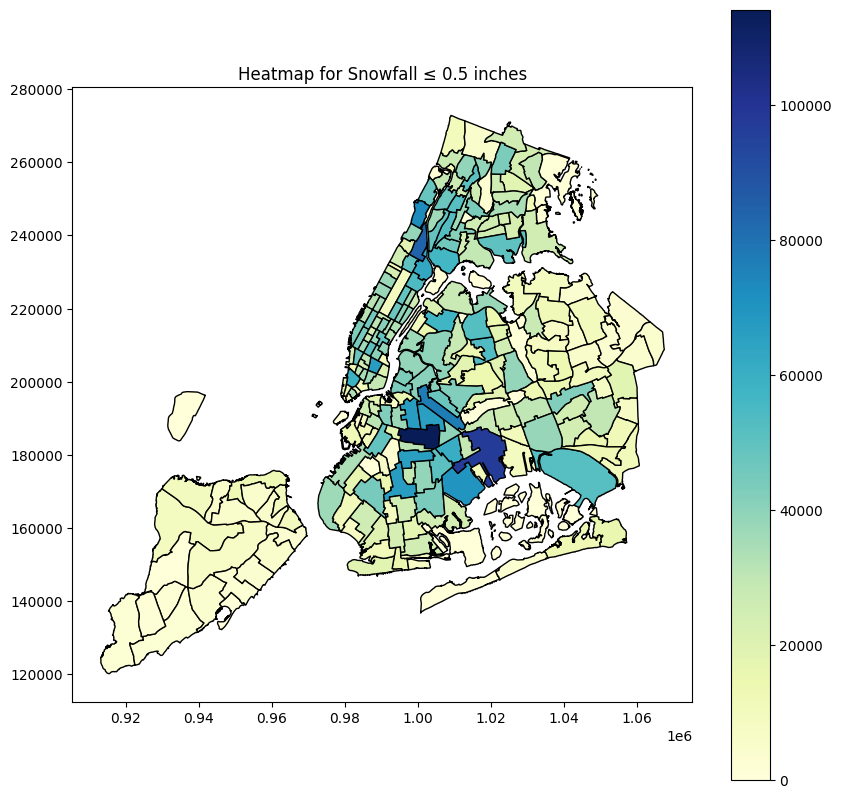

In [50]:
# Plot the map for snow <= 0.5
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zone_gdf_not_snow.plot(ax=ax, column="not_snow_count", legend=True, cmap="YlGnBu", edgecolor="black")
ax.set_title("Heatmap for Snowfall ≤ 0.5 inches")
plt.show()

In [51]:
#Relode the shape file
taxi_zone_gdf = gpd.read_file("taxi/taxi_zones/taxi_zones.shp")

In [52]:
# Convert the 'pickup_datetime' back to datetime format to extract the hour
trip_data['pickup_datetime'] = pd.to_datetime(trip_data['pickup_datetime'])

# Define a function to assign a time period based on hour
def assign_time_period(hour):
    if 7 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

# Apply the function to the dataframe
trip_data['time_period'] = trip_data['pickup_datetime'].dt.hour.apply(assign_time_period)

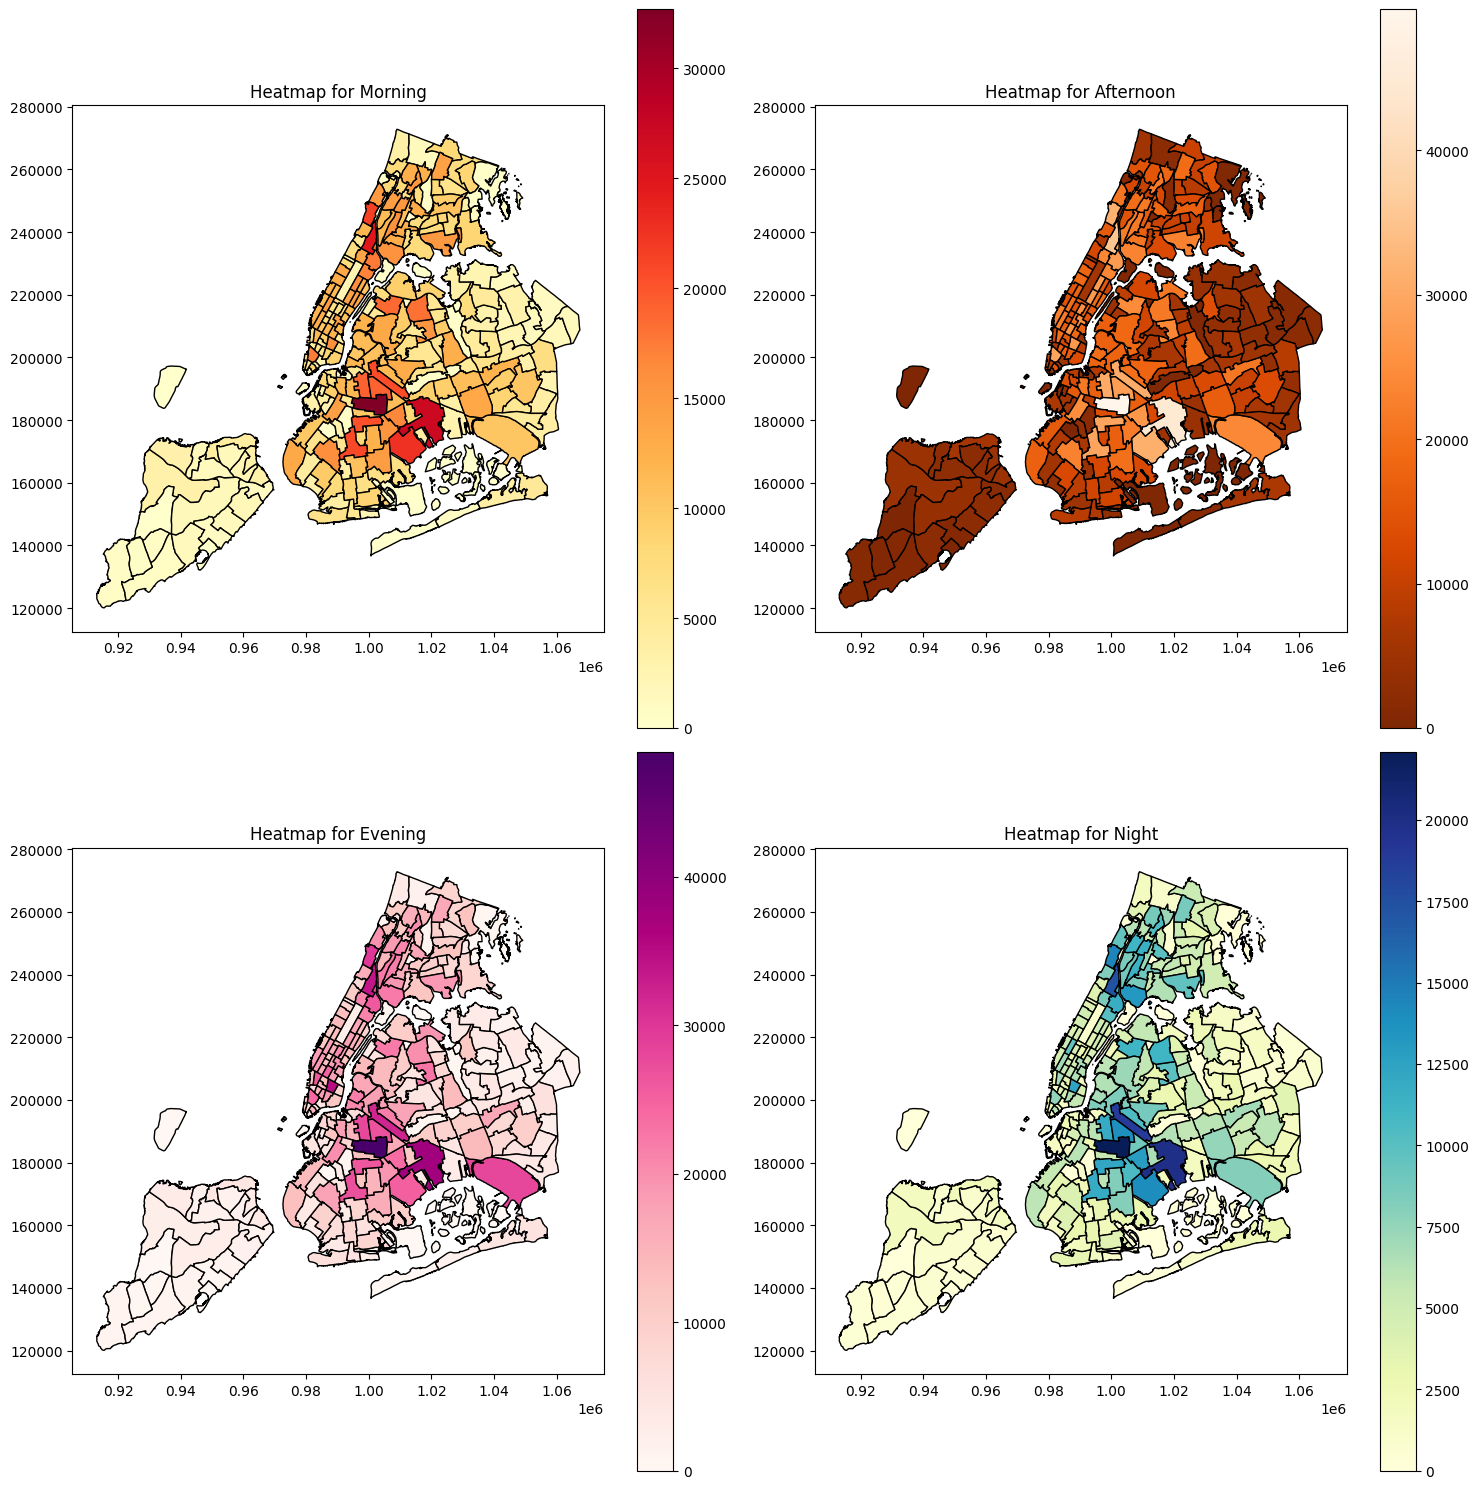

In [53]:
# Now, for each time period, we will calculate the pickup counts and plot the heatmap
time_periods = ["Morning", "Afternoon", "Evening", "Night"]
colormaps = ["YlOrRd", "Oranges_r", "RdPu", "YlGnBu" ] 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for time_period, cmap, ax in zip(time_periods, colormaps,axes.ravel()):
    subset = trip_data[trip_data['time_period'] == time_period]
    counts = subset["PULocationID"].value_counts().reset_index()
    counts.columns = ["LocationID", "pickup_count"]
    temp_gdf = taxi_zone_gdf.merge(counts, on="LocationID", how="left")
    temp_gdf["pickup_count"] = temp_gdf["pickup_count"].fillna(0).astype(float)

    temp_gdf.plot(ax=ax, column="pickup_count", legend=True, cmap=cmap, edgecolor="black")
    ax.set_title(f"Heatmap for {time_period}")
plt.tight_layout()
plt.show()

## <b>Preprocessing

### 1. Encoding

In [54]:
# List of columns to be converted
binary_columns = ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']

# Convert each column from 'Y'/'N' to 1/0
for column in binary_columns:
    trip_data[column] = trip_data[column].astype(str).replace({'Y': 1, 'N': 0})


C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\1294099011.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trip_data[column] = trip_data[column].astype(str).replace({'Y': 1, 'N': 0})
C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\1294099011.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  trip_data[column] = trip_data[column].astype(str).replace({'Y': 1, 'N': 0})
C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\1294099011.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fut

In [55]:
trip_data.isnull().sum()

hvfhs_license_num       0
dispatching_base_num    0
request_datetime        0
pickup_datetime         0
dropoff_datetime        0
PULocationID            0
DOLocationID            0
trip_miles              0
trip_time               0
base_passenger_fare     0
tolls                   0
bcf                     0
sales_tax               0
congestion_surcharge    0
tips                    0
driver_pay              0
shared_request_flag     0
shared_match_flag       0
access_a_ride_flag      0
wav_request_flag        0
wav_match_flag          0
pickup_date             0
time_period             0
dtype: int64

In [56]:
# Convert 'pickup_datetime' to datetime and determine if it's a weekday (1) or weekend (0)
trip_data['pickup_datetime'] = pd.to_datetime(trip_data['pickup_datetime'])
trip_data['weekday'] = np.where(trip_data['pickup_datetime'].dt.dayofweek < 5, 1, 0)

In [57]:
# Define the time periods and labels
bins = [0, 6, 11, 19, 23, 24]  # Hour intervals
labels = [4, 1, 2, 3, 4]  # Unique labels for each time period

# Use pd.cut to assign time periods based on 'pickup_time'
trip_data['pickup_time'] = pd.to_datetime(trip_data['pickup_datetime']).dt.hour
trip_data['pickup_time'] = pd.cut(trip_data['pickup_time'], bins=bins, labels=labels, right=False, include_lowest=True, ordered=False)

# Convert to integer type if needed
trip_data['pickup_time'] = trip_data['pickup_time'].astype(int)

Adding new column as Total Fare

In [58]:
# Add a new column to calculate the total fare
trip_data['total_fare'] = trip_data['base_passenger_fare'] + trip_data['tolls'] + trip_data['sales_tax'] + trip_data['congestion_surcharge']

#### Merging Dataframe (Trip, Weather and Zone)

In [59]:
# Creating new dataframe for trip_data
trip_data_jan = trip_data[['pickup_datetime', 'total_fare', 'trip_time', 'trip_miles', 'pickup_time', 'weekday', 'shared_match_flag', 'wav_match_flag', 'PULocationID', 'DOLocationID']]

In [60]:
trip_data_jan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8704128 entries, 0 to 11908467
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   pickup_datetime    datetime64[us]
 1   total_fare         float64       
 2   trip_time          int64         
 3   trip_miles         float64       
 4   pickup_time        int64         
 5   weekday            int64         
 6   shared_match_flag  int64         
 7   wav_match_flag     int64         
 8   PULocationID       int64         
 9   DOLocationID       int64         
dtypes: datetime64[us](1), float64(2), int64(7)
memory usage: 730.5 MB


In [61]:
# Creating new dataframe for weather
weather_jan_new = weather_jan[['temp', 'precip', 'snow', 'snowdepth', 'windspeed', 'visibility', 'datetime']]

In [62]:
# Merge the trip_data_jan and weather_jan_new
trip_data_jan['pickup_datetime'] = pd.to_datetime(trip_data_jan['pickup_datetime']).dt.date
weather_jan_new['datetime'] = pd.to_datetime(weather_jan_new['datetime']).dt.date
merged_data_jan = trip_data_jan.merge(weather_jan_new, left_on="pickup_datetime", right_on="datetime")

C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\749375876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_data_jan['pickup_datetime'] = pd.to_datetime(trip_data_jan['pickup_datetime']).dt.date
C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\749375876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_jan_new['datetime'] = pd.to_datetime(weather_jan_new['datetime']).dt.date


In [63]:
merged_data_jan.isnull().sum()

pickup_datetime      0
total_fare           0
trip_time            0
trip_miles           0
pickup_time          0
weekday              0
shared_match_flag    0
wav_match_flag       0
PULocationID         0
DOLocationID         0
temp                 0
precip               0
snow                 0
snowdepth            0
windspeed            0
visibility           0
datetime             0
dtype: int64

In [64]:
# Centers of taxi-zone
taxi_zone_gdf['center'] = taxi_zone_gdf.centroid

In [65]:
# Merge the merged_data and shape file
merged_data_jan = pd.merge(merged_data_jan, taxi_zone_gdf[['LocationID', 'center']], left_on='PULocationID', right_on='LocationID', how='left')

In [66]:
merged_data_jan.isnull().sum()
merged_data_jan.dropna(inplace=True)
merged_data_jan.head()

pickup_datetime  total_fare  trip_time  trip_miles  pickup_time  weekday  \
0      2021-01-01       27.01        923        5.26            4        1   
1      2021-01-01       19.99       1382        3.65            4        1   
2      2021-01-01       18.05        849        3.51            4        1   
3      2021-01-01       11.36        179        0.74            4        1   
4      2021-01-01       32.27       1228        9.20            4        1   

   shared_match_flag  wav_match_flag  PULocationID  DOLocationID  temp  \
0                  0               0           230           166   2.5   
1                  0               0           152           167   2.5   
2                  0               0           233           142   2.5   
3                  0               0           142           143   2.5   
4                  0               0           143            78   2.5   

   precip  snow  snowdepth  windspeed  visibility    datetime  LocationID  \
0   15.33   0.0        0.0       15.5        14.0  2021-01-01       230.0   
1   15.33   0.0        0.0       15.5        14.0  2021-01-01       152.0   
2   15.33   0.0        0.0       15.5        14.0  2021-01-01       233.0   
3   15.33   0.0        0.0       15.5        14.0  2021-01-01       142.0   
4   15.33   0.0        0.0       15.5        14.0  2021-01-01       143.0   

                          center  
0    POINT (988628.06 216099.14)  
1  POINT (997042.629 237290.907)  
2  POINT (992439.561 212491.936)  
3  POINT (989365.068 221132.775)  
4   POINT (987671.71 221982.085)

#### Cleaning The Merged Data

In [67]:
# import random
# from scipy.spatial import distance

# # Removing rows where 'center' is None or 'center' is not a valid geometry
# merged_data_jan = merged_data_jan[merged_data_jan['center'].notna()]

# # Ensuring 'center' is a valid geometry with x and y coordinates
# coordinates = list(merged_data_jan['center'].apply(lambda x: (x.x, x.y) if hasattr(x, 'x') and hasattr(x, 'y') else None))

# # Filtering out any None values in coordinates (in case there are invalid entries)
# coordinates = [coord for coord in coordinates if coord is not None]

# # Ensuring that coordinates is a 2D list (list of tuples/lists), with each element having 2 values
# assert all(len(coord) == 2 for coord in coordinates), "Each coordinate must be a tuple with 2 values."

# # Check if we have enough data points before sampling
# if len(coordinates) > 1000:
#     sampled_coords = random.sample(coordinates, 1000)
# else:
#     sampled_coords = coordinates  # Using all data if less than 1000

# # Calculating pairwise distances using scipy's pdist
# estimated_distances = distance.pdist(sampled_coords)

# # Getting min and max distance
# min_distance, max_distance = min(estimated_distances), max(estimated_distances)
# print(f"Min distance: {min_distance}, Max distance: {max_distance}")

In [68]:
# #Proximity-based edges
# import networkx as nx
# from scipy.spatial import distance

# # Create a graph
# G = nx.Graph()

# # Add nodes with location information (centroids)
# for index, row in taxi_zone_gdf.iterrows():
#     G.add_node(row['LocationID'], pos=row['center'].coords[0], label=row['zone'])

# # Increase the threshold to make sure distances are properly captured
# # Try using a larger threshold value (adjust based on your data's coordinate scale)
# threshold_distance = 1000  # You can experiment with this threshold

# # Add edges based on proximity (distance between centroids)
# for i in range(len(taxi_zone_gdf)):
#     for j in range(i + 1, len(taxi_zone_gdf)):
#         loc_i = taxi_zone_gdf.iloc[i]['center'].coords[0]
#         loc_j = taxi_zone_gdf.iloc[j]['center'].coords[0]
#         dist = distance.euclidean(loc_i, loc_j)
        
#         # Only add edges if the distance is below the threshold
#         if dist <= threshold_distance:
#             G.add_edge(taxi_zone_gdf.iloc[i]['LocationID'], taxi_zone_gdf.iloc[j]['LocationID'])

# # Draw the graph
# fig, ax = plt.subplots(figsize=(12, 12))

# # Get node positions
# pos = nx.get_node_attributes(G, 'pos')

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', ax=ax)

# # Draw edges
# nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black', width=1, ax=ax)

# # Add labels
# labels = nx.get_node_attributes(G, 'label')
# nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)

# # Set title and show plot
# ax.set_title("NYC Taxi Zones with Centroids and Proximity-based Edges")
# plt.show()


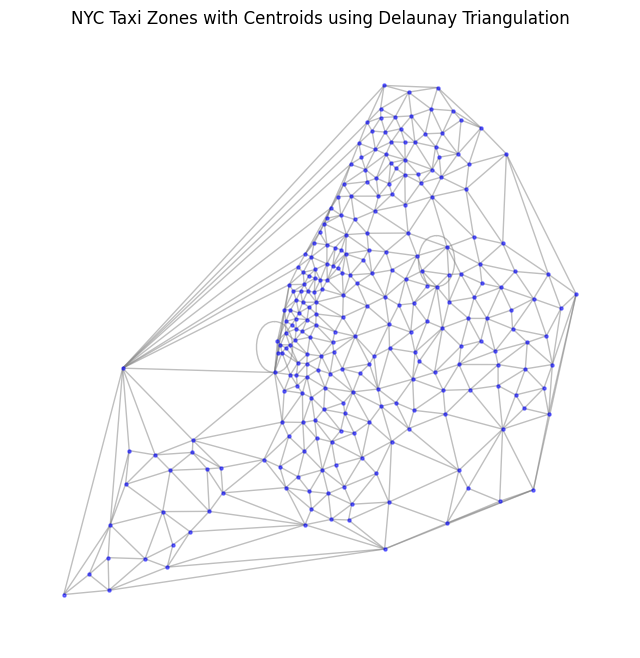

In [69]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Extract the centers of the taxi zones (ensure 'center' is a tuple or array of coordinates)
centers = [list(center.coords[0]) for center in taxi_zone_gdf['center']]
location_ids = taxi_zone_gdf['LocationID'].tolist()

# Compute the Delaunay triangulation
tri = Delaunay(centers)

# Create a new graph
G_delaunay = nx.Graph()

# Add nodes to the graph with their position and label
for index, row in taxi_zone_gdf.iterrows():
    G_delaunay.add_node(row['LocationID'], pos=row['center'].coords[0], label=row['zone'])

# Add edges to the graph based on the Delaunay triangulation
for simplex in tri.simplices:
    edges = [(location_ids[simplex[i]], location_ids[simplex[j]]) for i, j in [(0, 1), (1, 2), (2, 0)]]
    G_delaunay.add_edges_from(edges)

# Draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G_delaunay, pos=nx.get_node_attributes(G_delaunay, 'pos'), 
        node_size=5, node_color='blue', edge_color='gray', alpha=0.5, ax=ax)
ax.set_title("NYC Taxi Zones with Centroids using Delaunay Triangulation")
plt.show()


## <b>Model Building

In [70]:
trip_data_jan.head()

pickup_datetime  total_fare  trip_time  trip_miles  pickup_time  weekday  \
0      2021-01-01       27.01        923        5.26            4        1   
1      2021-01-01       19.99       1382        3.65            4        1   
2      2021-01-01       18.05        849        3.51            4        1   
3      2021-01-01       11.36        179        0.74            4        1   
4      2021-01-01       32.27       1228        9.20            4        1   

   shared_match_flag  wav_match_flag  PULocationID  DOLocationID  
0                  0               0           230           166  
1                  0               0           152           167  
2                  0               0           233           142  
3                  0               0           142           143  
4                  0               0           143            78

In [71]:
# trip_data_jan.to_parquet('C:/Users/adnan/OneDrive/Desktop/Dynamic Pricing Project/Final_Data/trip_data_jan.parquet', engine='pyarrow')

In [72]:
weather_jan_new.head()

temp  precip  snow  snowdepth  windspeed  visibility    datetime
0   2.5   15.33   0.0        0.0       15.5        14.0  2021-01-01
1   5.8    2.38   1.9        0.6       25.5        12.2  2021-01-02
2   2.5    5.09   1.2        1.7       24.1        13.2  2021-01-03
3   3.6    0.84   0.5        0.7       17.3        15.6  2021-01-04
4   3.8     0.0   0.0        0.1       15.2        16.0  2021-01-05

In [73]:
# weather_jan_new.to_csv('C:/Users/adnan/OneDrive/Desktop/Dynamic Pricing Project/Final_Data/weather_jan_new.csv', index=False)

In [74]:
taxi_zone_gdf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

                           center  
0    POINT (935996.821 191376.75)  
1  POINT (1031085.719 164018.754)  
2  POINT (1026452.617 254265.479)  
3   POINT (990633.981 202959.782)  
4    POINT (931871.37 140681.351)

In [75]:
# taxi_zone_gdf.to_csv('C:/Users/adnan/OneDrive/Desktop/Dynamic Pricing Project/Final_Data/taxi_zone_gdf.csv', index=False)

#### Creating Final Dataset

In [76]:
# Copy of the taxi_zone_gdf
taxi_zone_gdf_PU = taxi_zone_gdf.copy()
taxi_zone_gdf_DO = taxi_zone_gdf.copy()

# Rename the columns of taxi_zone_gdf_PU and taxi_zone_gdf_DO
taxi_zone_gdf_PU = taxi_zone_gdf_PU.add_prefix('PU_')
taxi_zone_gdf_DO = taxi_zone_gdf_DO.add_prefix('DO_')


In [77]:
taxi_zone_gdf_DO.head()
taxi_zone_gdf_PU.head()

PU_OBJECTID  PU_Shape_Leng  PU_Shape_Area                  PU_zone  \
0            1       0.116357       0.000782           Newark Airport   
1            2       0.433470       0.004866              Jamaica Bay   
2            3       0.084341       0.000314  Allerton/Pelham Gardens   
3            4       0.043567       0.000112            Alphabet City   
4            5       0.092146       0.000498            Arden Heights   

   PU_LocationID     PU_borough  \
0              1            EWR   
1              2         Queens   
2              3          Bronx   
3              4      Manhattan   
4              5  Staten Island   

                                         PU_geometry  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  POLYGON ((935843.31 144283.336, 936046.565 144...   

                        PU_center  
0    POINT (935996.821 191376.75)  
1  POINT (1031085.719 164018.754)  
2  POINT (1026452.617 254265.479)  
3   POINT (990633.981 202959.782)  
4    POINT (931871.37 140681.351)

In [78]:
# # Save taxi_zone_gdf_DO as a GDF file
# taxi_zone_gdf_DO.to_csv('C:/Users/adnan/OneDrive/Desktop/Dynamic Pricing Project/Final_Data/taxi_zone_gdf_DO.csv', index=False)

# # Save taxi_zone_gdf_PU as a GDF file
# taxi_zone_gdf_PU.to_csv('C:/Users/adnan/OneDrive/Desktop/Dynamic Pricing Project/Final_Data/taxi_zone_gdf_PU.csv',index=False)

In [79]:
# merge the data set base on PULocationID
merged_data_PU = trip_data_jan.merge(taxi_zone_gdf_PU, left_on="PULocationID", right_on="PU_LocationID")

# merge the data set base on DOLocationID
final_taxi_data = merged_data_PU.merge(taxi_zone_gdf_DO, left_on="DOLocationID", right_on="DO_LocationID")

In [80]:
final_taxi_data.head()

pickup_datetime  total_fare  trip_time  trip_miles  pickup_time  weekday  \
0      2021-01-01       27.01        923        5.26            4        1   
1      2021-01-01       19.99       1382        3.65            4        1   
2      2021-01-01       18.05        849        3.51            4        1   
3      2021-01-01       11.36        179        0.74            4        1   
4      2021-01-01       32.27       1228        9.20            4        1   

   shared_match_flag  wav_match_flag  PULocationID  DOLocationID  ...  \
0                  0               0           230           166  ...   
1                  0               0           152           167  ...   
2                  0               0           233           142  ...   
3                  0               0           142           143  ...   
4                  0               0           143            78  ...   

                                         PU_geometry  \
0  POLYGON ((988786.877 214532.094, 988650.277 21...   
1  POLYGON ((997099.866 238748.57, 997283.238 238...   
2  MULTIPOLYGON (((993816.792 213230.43, 993857.4...   
3  POLYGON ((989380.305 218980.247, 989359.803 21...   
4  POLYGON ((989338.1 223572.253, 989368.225 2235...   

                       PU_center  DO_OBJECTID DO_Shape_Leng  DO_Shape_Area  \
0    POINT (988628.06 216099.14)          166      0.068824       0.000255   
1  POINT (997042.629 237290.907)          167      0.090816       0.000168   
2  POINT (992439.561 212491.936)          142      0.038176       0.000076   
3  POINT (989365.068 221132.775)          143      0.054180       0.000151   
4   POINT (987671.71 221982.085)           78      0.093594       0.000191   

               DO_zone DO_LocationID DO_borough  \
0  Morningside Heights           166  Manhattan   
1   Morrisania/Melrose           167      Bronx   
2  Lincoln Square East           142  Manhattan   
3  Lincoln Square West           143  Manhattan   
4         East Tremont            78      Bronx   

                                         DO_geometry  \
0  POLYGON ((996131.213 235950.777, 996354.986 23...   
1  POLYGON ((1012781.409 242061.913, 1012706.412 ...   
2  POLYGON ((989380.305 218980.247, 989359.803 21...   
3  POLYGON ((989338.1 223572.253, 989368.225 2235...   
4  POLYGON ((1014782.254 250130.965, 1014697.776 ...   

                       DO_center  
0  POINT (994834.787 234186.327)  
1  POINT (1011274.103 240777.45)  
2  POINT (989365.068 221132.775)  
3   POINT (987671.71 221982.085)  
4  POINT (1015923.651 247139.97)  

[5 rows x 26 columns]

In [81]:
final_taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8532348 entries, 0 to 8532347
Data columns (total 26 columns):
 #   Column             Dtype   
---  ------             -----   
 0   pickup_datetime    object  
 1   total_fare         float64 
 2   trip_time          int64   
 3   trip_miles         float64 
 4   pickup_time        int64   
 5   weekday            int64   
 6   shared_match_flag  int64   
 7   wav_match_flag     int64   
 8   PULocationID       int64   
 9   DOLocationID       int64   
 10  PU_OBJECTID        int32   
 11  PU_Shape_Leng      float64 
 12  PU_Shape_Area      float64 
 13  PU_zone            object  
 14  PU_LocationID      int32   
 15  PU_borough         object  
 16  PU_geometry        geometry
 17  PU_center          geometry
 18  DO_OBJECTID        int32   
 19  DO_Shape_Leng      float64 
 20  DO_Shape_Area      float64 
 21  DO_zone            object  
 22  DO_LocationID      int32   
 23  DO_borough         object  
 24  DO_geometry        geome

In [82]:
final_taxi_data = final_taxi_data.merge(weather_jan_new, left_on="pickup_datetime", right_on="datetime")

In [83]:
# dropping the duplicate columns
final_taxi_data = final_taxi_data.drop(columns=['PU_LocationID', 'DO_LocationID', 'pickup_datetime'])

In [84]:
# Find max and min of PULocationID and DOLocationID in final_taxi_data
pu_max = final_taxi_data['PULocationID'].max()
pu_min = final_taxi_data['PULocationID'].min()
do_max = final_taxi_data['DOLocationID'].max()
do_min = final_taxi_data['DOLocationID'].min()

# Find max and min of LocationID in taxi_zones_gdf
location_max = taxi_zone_gdf['LocationID'].max()
location_min = taxi_zone_gdf['LocationID'].min()

# Print all results at once
print(f"PULocationID - Max: {pu_max}, Min: {pu_min}")
print(f"DOLocationID - Max: {do_max}, Min: {do_min}")
print(f"LocationID in taxi_zones_gdf - Max: {location_max}, Min: {location_min}")


PULocationID - Max: 263, Min: 1
DOLocationID - Max: 263, Min: 1
LocationID in taxi_zones_gdf - Max: 263, Min: 1


#### Build Network Using Location ID

In [85]:
import networkx as nx

# Creating an empty graph
graph = nx.Graph()

# Batch add nodes with all taxi zone information
nodes_data = [
    (row.LocationID, {
        'objectid': row.OBJECTID,
        'shape_length': row.Shape_Leng,
        'shape_area': row.Shape_Area,
        'zone': row.zone,
        'borough': row.borough,
        'geometry': row.geometry,
        'center': row.center
    })
    for row in taxi_zone_gdf.itertuples()
]


# Add all nodes at once
graph.add_nodes_from(nodes_data)

In [86]:
# Define the relevant columns for edge creation
relevant_trip_columns = ['PULocationID', 'DOLocationID', 'temp', 'precip', 'snow', 'windspeed', 'visibility', 
                         'total_fare', 'trip_time', 'trip_miles', 'pickup_time', 'weekday', 
                         'shared_match_flag', 'wav_match_flag']

# Batch add edges with relevant trip and weather information
edges_data = [
    (row.PULocationID, row.DOLocationID, {
        'temp': row.temp,
        'precip': row.precip,
        'snow': row.snow,
        'windspeed': row.windspeed,
        'visibility': row.visibility,
        'total_fare': row.total_fare,
        'trip_time': row.trip_time,
        'trip_miles': row.trip_miles,
        'pickup_time': row.pickup_time,
        'weekday': row.weekday,
        'shared_match_flag': row.shared_match_flag,
        'wav_match_flag': row.wav_match_flag
    })
    for row in final_taxi_data[relevant_trip_columns].itertuples()
]

# Add all edges at once
graph.add_edges_from(edges_data)

# Check the size of the graph for verification
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 260
Number of edges: 29053


#### Checking for Missing LocationID

In [87]:
import networkx as nx

# Define the iteration range based on the original code
iteration_range = range(1, len(graph.nodes) + 1)

# Convert relevant columns to sets for faster lookup
pulocation_tripdata_set = set(trip_data_jan['PULocationID'].unique())
dolocation_tripdata_set = set(trip_data_jan['DOLocationID'].unique())
pulocation_final_set = set(final_taxi_data['PULocationID'].unique())
dolocation_final_set = set(final_taxi_data['DOLocationID'].unique())

# Function to find missing IDs in a given set
def find_missing_ids(iter_range, id_set):
    return [i for i in iter_range if i not in id_set]

# Find missing LocationIDs
missing_pu_tripdata = find_missing_ids(iteration_range, pulocation_tripdata_set)
missing_do_tripdata = find_missing_ids(iteration_range, dolocation_tripdata_set)
missing_pu_final = find_missing_ids(iteration_range, pulocation_final_set)
missing_do_final = find_missing_ids(iteration_range, dolocation_final_set)

# Print the missing LocationIDs
print("Missing PULocationIDs in trip_data_jan:")
for i in missing_pu_tripdata:
    print(i)

print("\nMissing DOLocationIDs in trip_data_jan:")
for i in missing_do_tripdata:
    print(i)

print("\nMissing PULocationIDs in final_taxi_data:")
for i in missing_pu_final:
    print(i)

print("\nMissing DOLocationIDs in final_taxi_data:")
for i in missing_do_final:
    print(i)


Missing PULocationIDs in trip_data_jan:
103
104
105

Missing DOLocationIDs in trip_data_jan:
103
105
199

Missing PULocationIDs in final_taxi_data:
57
103
104
105

Missing DOLocationIDs in final_taxi_data:
57
103
104
105
199


In [88]:
# Define the list of LocationIDs to be dropped
ids_to_drop = [57, 103, 104, 105, 199]

# Drop rows in final_merged_data where PULocationID or DOLocationID is in the list
final_taxi_data = final_taxi_data[~final_taxi_data['PULocationID'].isin(ids_to_drop)]
final_taxi_data = final_taxi_data[~final_taxi_data['DOLocationID'].isin(ids_to_drop)]

# Drop rows in taxi_zones_gdf where LocationID is in the list
taxi_zone_gdf = taxi_zone_gdf[~taxi_zone_gdf['LocationID'].isin(ids_to_drop)]


In [89]:
taxi_zone_gdf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

                           center  
0    POINT (935996.821 191376.75)  
1  POINT (1031085.719 164018.754)  
2  POINT (1026452.617 254265.479)  
3   POINT (990633.981 202959.782)  
4    POINT (931871.37 140681.351)

Saving Taxi Zone for Further Modeling

In [90]:
# # Drop the 'center' column 
# taxi_zone_gdf_geo = taxi_zone_gdf.drop(columns=['center'])
# taxi_zone_gdf_geo.to_file('C:/Users/adnan/Python/CAPSTONE/taxi_zone_geometry.shp', driver='ESRI Shapefile')

# #Drop the geometry column
# taxi_zone_gdf_cen = taxi_zone_gdf.drop(columns=['geometry'])
# # Set 'center' as the active geometry column and save as shapefile
# taxi_zone_gdf_cen.to_file('C:/Users/adnan/Python/CAPSTONE/taxi_zone_center.shp', driver='ESRI Shapefile')

#### Visualizing the Trip Graph

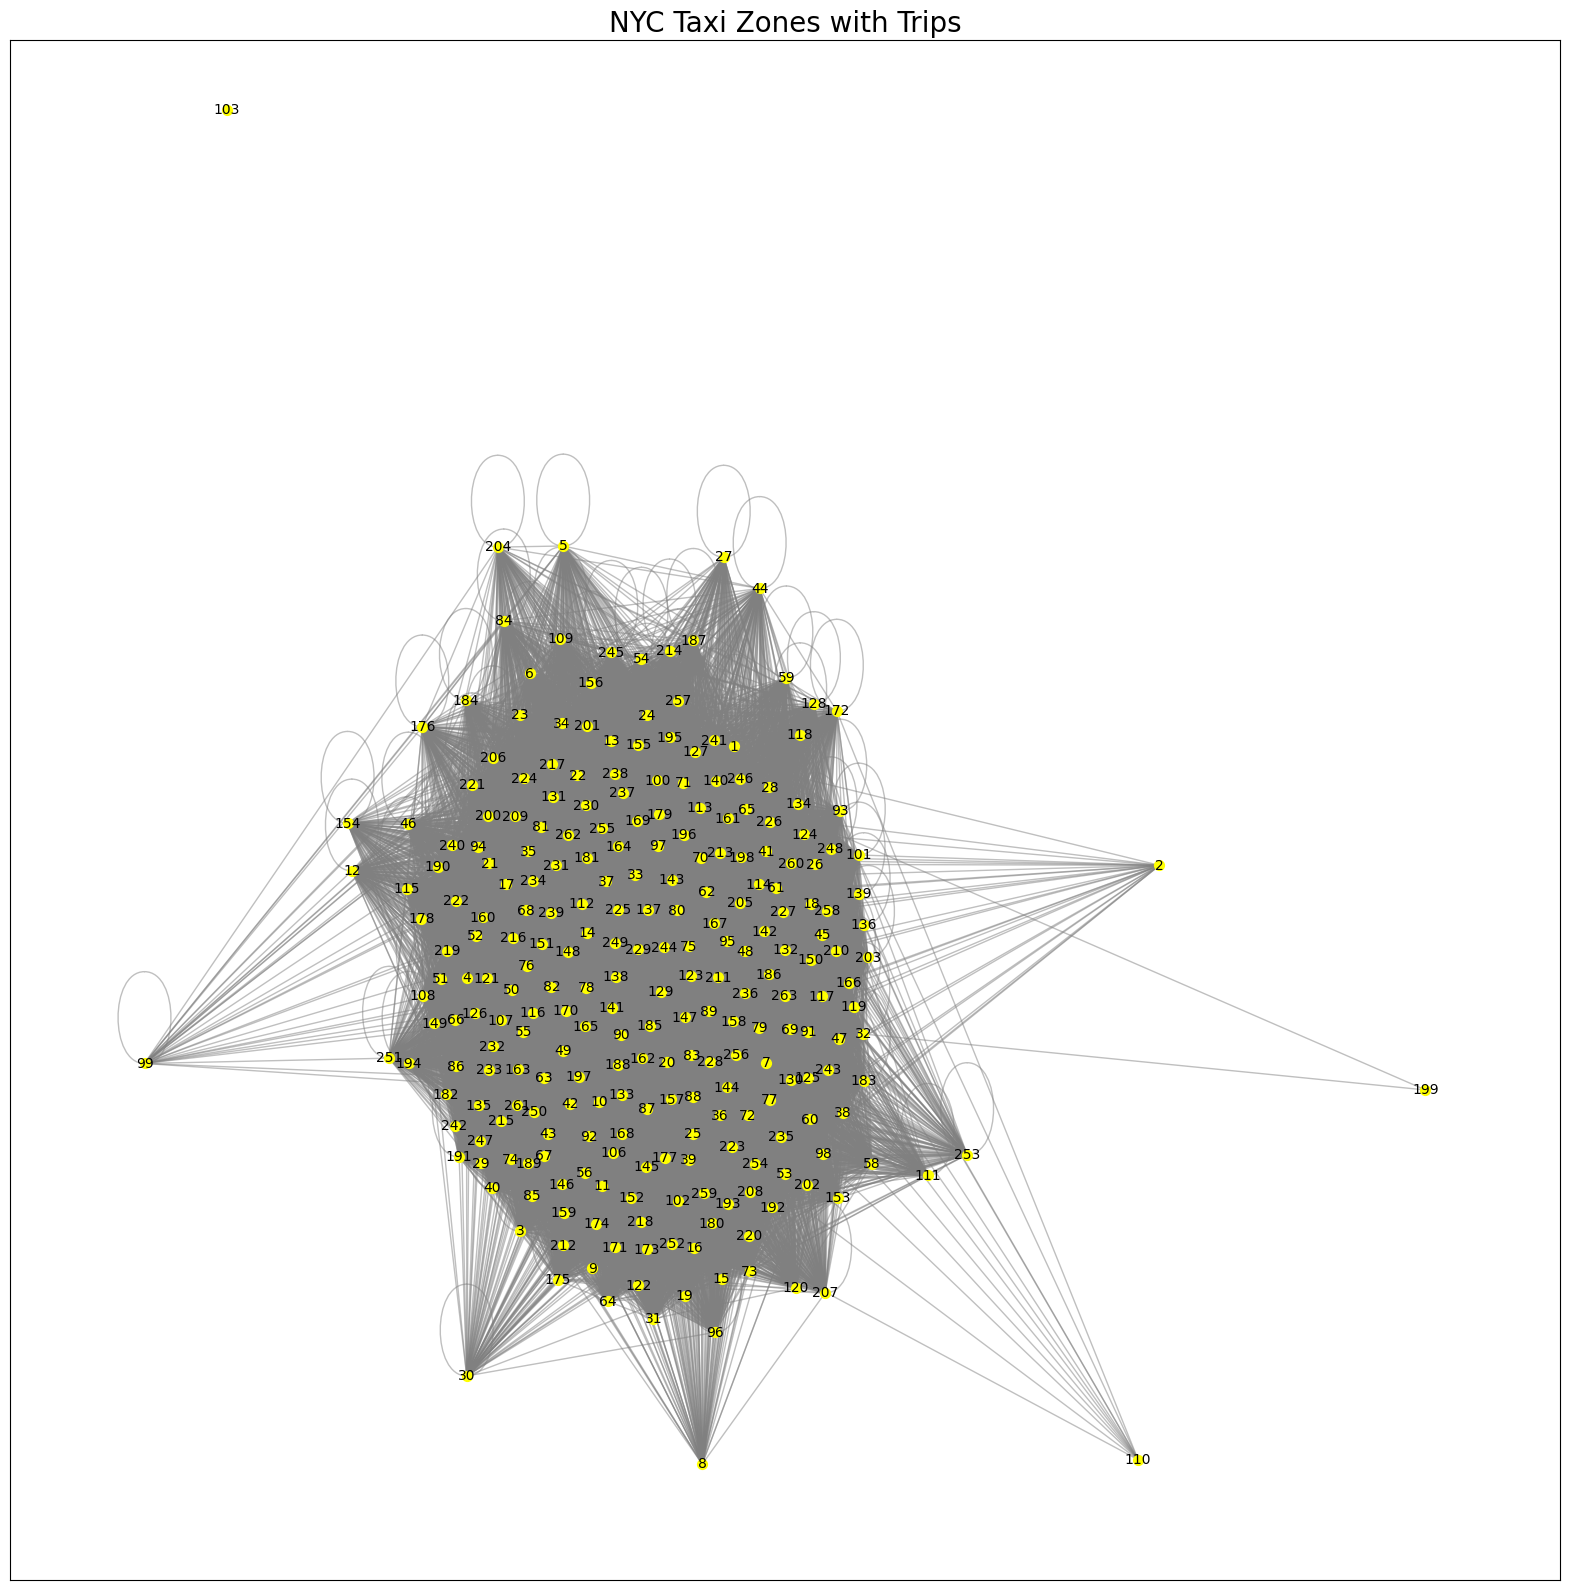

In [91]:
# Visualize the graph with optimized settings
plt.figure(figsize=(20, 20))

# Use a spring layout for better distribution of nodes
pos = nx.spring_layout(graph, k=1, seed=42)  # Adding a seed for reproducibility

# Draw the nodes with labels
nx.draw_networkx_nodes(graph, pos, node_color='yellow', node_size=50)

# Draw the edges
nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5)

# Draw the node labels
nx.draw_networkx_labels(graph, pos, font_size=10)

# Set the title
plt.title("NYC Taxi Zones with Trips", fontsize=20)

# Display the graph
plt.show()


### Data Preprocess

In [92]:
# creating a dataframe with the required columns
model_data = final_taxi_data[['PULocationID', 'DOLocationID', 'total_fare', 'trip_time', 'trip_miles', 'pickup_time', 'weekday', 'shared_match_flag', 'wav_match_flag', 'temp', 'precip', 'snow', 'snowdepth', 'windspeed', 'visibility']]

In [93]:
#model_data.to_parquet('C:/Users/adnan/Python/CAPSTONE/model_data.parquet', engine='pyarrow')

In [94]:
# Find numeric columns, excluding PULocationID and DOLocationID
num_columns = model_data.select_dtypes(include=np.number).columns.tolist()
num_columns.remove('PULocationID')
num_columns.remove('DOLocationID')

# Compute the average of each trip feature by group
grouped = model_data.groupby(['PULocationID', 'DOLocationID'])[num_columns].mean()

# Get the number of unique destinations (taxi zones) and feature length
num_destinations = len(taxi_zone_gdf['LocationID'])
feature_length = len(grouped.columns)

# Calculate the total feature length for all destination pairs
total_feature_length = num_destinations * feature_length

# Display results
print(f"Number of destinations: {num_destinations}")
print(f"Number of features per destination pair: {feature_length}")
print(f"Total feature length: {total_feature_length}")


Number of destinations: 259
Number of features per destination pair: 13
Total feature length: 3367


In [95]:
# convert the node features to a tensor for further use
node_features_list = []
for loc_id in taxi_zone_gdf['LocationID']:
    loc_features = np.zeros(total_feature_length)
    for i, dest_id in enumerate(taxi_zone_gdf['LocationID']):
        if (loc_id, dest_id) in grouped.index:
            start_idx = i * feature_length
            loc_features[start_idx:start_idx + feature_length] = grouped.loc[(loc_id, dest_id)].values
    node_features_list.append(loc_features)

node_features_tensor = torch.tensor(node_features_list, dtype=torch.float)

C:\Users\adnan\AppData\Local\Temp\ipykernel_25204\3765076641.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  node_features_tensor = torch.tensor(node_features_list, dtype=torch.float)


In [96]:
print(f"Grouped DataFrame columns: {grouped.columns}")

Grouped DataFrame columns: Index(['total_fare', 'trip_time', 'trip_miles', 'pickup_time', 'weekday',
       'shared_match_flag', 'wav_match_flag', 'temp', 'precip', 'snow',
       'snowdepth', 'windspeed', 'visibility'],
      dtype='object')


In [97]:
# Create a map mapping LocationID to 0-based index because we have deleted location ID
# Using mapping IDs to make IDs continuous to prevent errors
location_to_index = {loc_id: idx for idx, loc_id in enumerate(sorted(taxi_zone_gdf['LocationID']))}

# Prepare goal matrix
target_matrix = np.zeros((num_destinations, num_destinations))
for loc_id in taxi_zone_gdf['LocationID']:
    for dest_id in taxi_zone_gdf['LocationID']:
        if (loc_id, dest_id) in grouped.index:
            # Use mapping to index
            loc_idx = location_to_index[loc_id]
            dest_idx = location_to_index[dest_id]
            target_matrix[loc_idx, dest_idx] = grouped.loc[(loc_id, dest_id), 'total_fare']

target_tensor = torch.tensor(target_matrix, dtype=torch.float)


In [98]:
# Build the graph
graph = nx.Graph()

# Add nodes
for loc_id in taxi_zone_gdf['LocationID']:
    node_index = location_to_index[loc_id]
    graph.add_node(node_index, features=node_features_tensor[node_index])

# Add edges
for loc_id in taxi_zone_gdf['LocationID']:
    for dest_id in taxi_zone_gdf['LocationID']:
        if (loc_id, dest_id) in grouped.index:
            graph.add_edge(location_to_index[loc_id], location_to_index[dest_id])


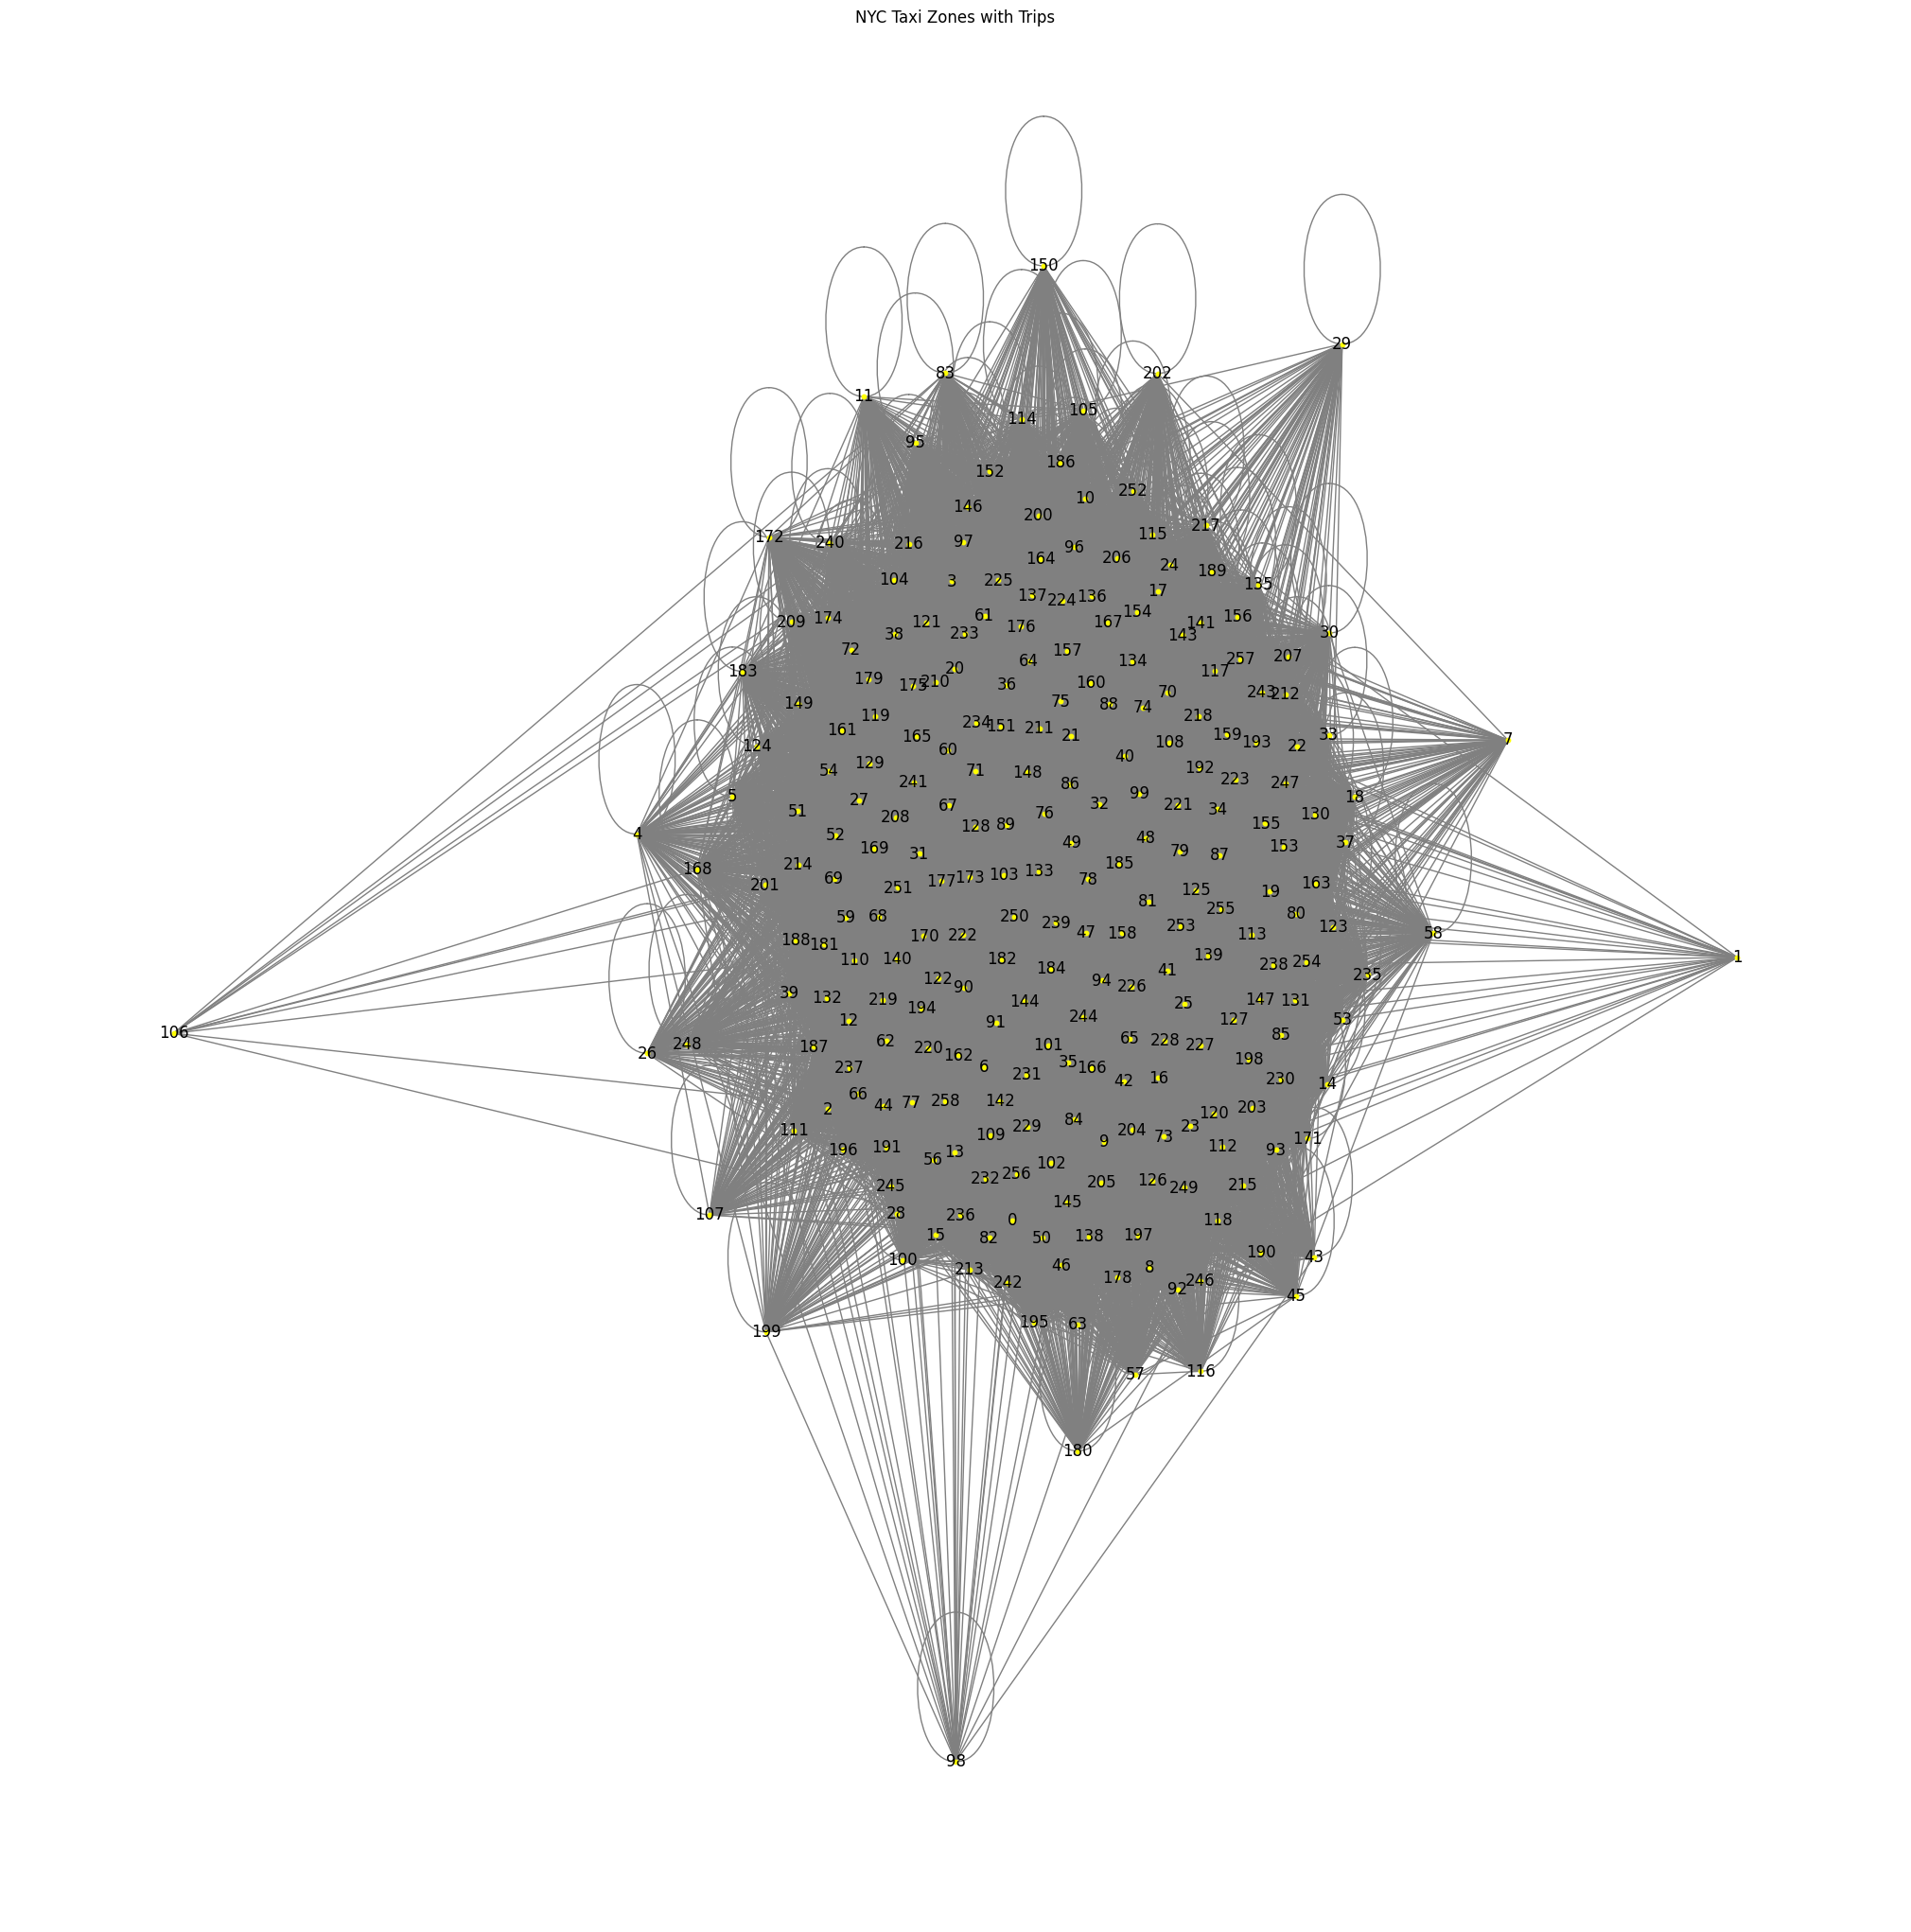

In [99]:
# visualize the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(graph, k=1)
nx.draw(graph, pos, with_labels=True, node_color='yellow', node_size=10, edge_color='gray')
plt.title("NYC Taxi Zones with Trips")
plt.show()

### GCN Model 1

In [100]:
# Get the edge index
edge_index = torch.tensor([list(pair) for pair in graph.edges()]).t().contiguous()

In [101]:
# prepare the data
data = Data(x=node_features_tensor, edge_index=edge_index, y=target_tensor)

In [102]:
# split the data into train and test and validate
num_nodes = data.x.shape[0]
indices = list(range(num_nodes))
np.random.shuffle(indices)

train_split = int(num_nodes * 0.6)
val_split = int(num_nodes * 0.2)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_split]] = True
val_mask[indices[train_split:train_split + val_split]] = True
test_mask[indices[train_split + val_split:]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [103]:
# define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        # output dim is the number of destinations
        self.conv2 = GCNConv(16, num_destinations)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_features=total_feature_length)

In [104]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

# Train the model 
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(12000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = loss_func(out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss}")

Epoch 0, Train Loss: 161669.6719, Val Loss: 158713.6875
Epoch 1000, Train Loss: 1143.5066, Val Loss: 1229.1271
Epoch 2000, Train Loss: 860.6235, Val Loss: 967.1450
Epoch 3000, Train Loss: 850.4461, Val Loss: 887.3918
Epoch 4000, Train Loss: 684.0023, Val Loss: 724.7053
Epoch 5000, Train Loss: 512.5912, Val Loss: 708.3244
Epoch 6000, Train Loss: 477.5455, Val Loss: 558.2079
Epoch 7000, Train Loss: 476.6303, Val Loss: 526.5969
Epoch 8000, Train Loss: 461.4811, Val Loss: 520.1255
Epoch 9000, Train Loss: 460.2881, Val Loss: 522.7745
Epoch 10000, Train Loss: 464.7059, Val Loss: 516.9130
Epoch 11000, Train Loss: 459.9157, Val Loss: 514.1542
Best Epoch: 11279, Best Validation Loss: 513.9019165039062


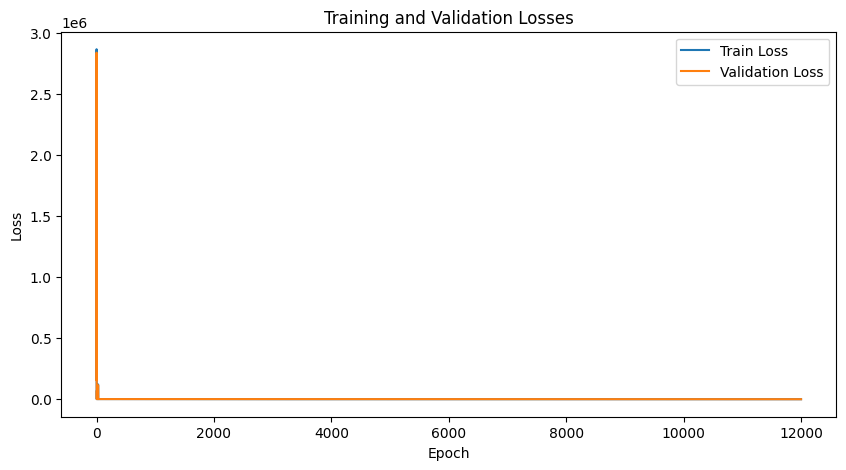

In [105]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [106]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    pred = model(data)
    test_loss = loss_func(pred[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item()}')

Test Loss: 483.2310791015625


In [107]:
# use the best model to predict the test set
model = GCN(num_features=total_feature_length)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(best_epoch + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
# Save the best model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': best_epoch,
    'best_val_loss': best_val_loss
}, "C:/Users/adnan/Python/CAPSTONE/best_gcn_model.pth")

In [ ]:
# # Load the saved model
# checkpoint = torch.load("C:/Users/adnan/Python/CAPSTONE/best_gcn_model.pth")

# # Initialize the model with the same architecture
# model = GCN(num_features=total_feature_length)

In [108]:
# Switch to evaluation mode
model.eval()

# Predict the total fare from location 1 to other locations
with torch.no_grad():
    pred = model(data)
    test_loss = loss_func(pred[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item()}')

# Convert the tensor to a numpy array
predicted_fares = pred.numpy()

# Open a file to write the predicted fares
with open("C:/Users/adnan/Python/CAPSTONE/predicted_fares.txt", "w") as file:
    for i, loc_id in enumerate(taxi_zone_gdf['LocationID']):
        file.write(f"Predicted fares from Location {loc_id} to others:\n")
        for j, dest_id in enumerate(taxi_zone_gdf['LocationID']):
            file.write(f"  To Location {dest_id}: {predicted_fares[i, j]:.2f}\n")
        file.write("\n")

print("Predicted fares have been saved to 'predicted_fares.txt'")

Test Loss: 483.6373291015625
Predicted fares have been saved to 'predicted_fares.txt'


In [109]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten predictions and target values for evaluation
pred_flat = pred.cpu().numpy().flatten()  # Predicted fares (flatten the 2D matrix into 1D)
target_flat = data.y.cpu().numpy().flatten()  # Actual fares (flattened)

# Create a pairwise test mask based on the origin-destination pairs
num_destinations = data.y.shape[0]
pairwise_mask = np.zeros((num_destinations, num_destinations), dtype=bool)

# Fill the pairwise mask based on individual node test_mask
for i in range(num_destinations):
    if data.test_mask[i]:
        pairwise_mask[i, :] = True  # Include all pairs where the origin is in the test set
        pairwise_mask[:, i] = True  # Include all pairs where the destination is in the test set

# Flatten the pairwise mask to match the shape of the flattened predictions
pairwise_mask_flat = pairwise_mask.flatten()

# Apply the pairwise mask to filter valid node pairs for evaluation
pred_test_pairs = pred_flat[pairwise_mask_flat]
target_test_pairs = target_flat[pairwise_mask_flat]

# 1. Calculate RMSE
rmse = np.sqrt(mean_squared_error(target_test_pairs, pred_test_pairs))
print(f'RMSE: {rmse:.4f}')

# 2. Calculate MAE
mae = mean_absolute_error(target_test_pairs, pred_test_pairs)
print(f'MAE: {mae:.4f}')

RMSE: 21.7989
MAE: 16.7779


### Tuned GCN Model 1

In [110]:
# # Define GCN model class
# class GCN_tuned(torch.nn.Module):
#     def __init__(self, num_features, hidden_units, dropout_rate):
#         super(GCN_tuned, self).__init__()
#         self.conv1 = GCNConv(num_features, hidden_units)
#         self.conv2 = GCNConv(hidden_units, num_destinations)
#         self.dropout_rate = dropout_rate

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=self.dropout_rate, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x

In [111]:
# # Hyperparameter ranges for random search
# lr_range = [0.001, 0.005, 0.01, 0.05, 0.1]
# hidden_units_range = [16, 32]
# dropout_range = [0.3, 0.5]
# epochs = 10000  # Set the number of epochs to train

In [112]:
# # Random search function
# def random_search(num_trials=50):
#     best_val_loss = float('inf')
#     best_params = None
    
#     # Perform num_trials iterations of random search
#     for trial in range(num_trials):
#         # Randomly select hyperparameters
#         lr = random.choice(lr_range)
#         hidden_units = random.choice(hidden_units_range)
#         dropout_rate = random.choice(dropout_range)

#         # Initialize model, optimizer, and loss function with selected hyperparameters
#         model = GCN_tuned(num_features=total_feature_length, hidden_units=hidden_units, dropout_rate=dropout_rate)
#         optimizer = optim.Adam(model.parameters(), lr=lr)
#         loss_func = torch.nn.MSELoss()

#         # Training loop
#         best_val_loss_trial = float('inf')
#         for epoch in range(epochs):
#             model.train()
#             optimizer.zero_grad()
#             out = model(data)
#             loss = loss_func(out[data.train_mask], data.y[data.train_mask])
#             loss.backward()
#             optimizer.step()

#             # Validation step
#             model.eval()
#             with torch.no_grad():
#                 val_loss = loss_func(out[data.val_mask], data.y[data.val_mask])
            
#             # Track the best validation loss
#             if val_loss < best_val_loss_trial:
#                 best_val_loss_trial = val_loss

#         # Update the best hyperparameters if current trial is better
#         if best_val_loss_trial < best_val_loss:
#             best_val_loss = best_val_loss_trial
#             best_params = {
#                 'learning_rate': lr,
#                 'hidden_units': hidden_units,
#                 'dropout_rate': dropout_rate
#             }

#         print(f'Trial {trial+1}/{num_trials} - LR: {lr}, Hidden Units: {hidden_units}, Dropout: {dropout_rate}, Best Val Loss: {best_val_loss_trial:.4f}')

#     print("\nBest hyperparameters found:")
#     print(f"Learning Rate: {best_params['learning_rate']}")
#     print(f"Hidden Units: {best_params['hidden_units']}")
#     print(f"Dropout Rate: {best_params['dropout_rate']}")
#     print(f"Best Validation Loss: {best_val_loss:.4f}")

# # Run the random search for hyperparameter tuning
# random_search(num_trials=20)

In [113]:
#  Once the best hyperparameters are found, retrain the model on the full training set
# # using these hyperparameters, and evaluate on the test set
# best_model = GCN_tuned(
#     num_features=total_feature_length,
#     hidden_units=best_params['hidden_units'],
#     dropout_rate=best_params['dropout_rate']
# )
# optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

# # Train with best hyperparameters
# for epoch in range(epochs):
#     best_model.train()
#     optimizer.zero_grad()
#     out = best_model(data)
#     loss = loss_func(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()

# # Evaluate on test set
# best_model.eval()
# with torch.no_grad():
#     pred = best_model(data)
#     test_loss = loss_func(pred[data.test_mask], data.y[data.test_mask])
#     print(f'\nTest Loss with best model: {test_loss:.4f}')

In [114]:
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Flatten predictions and target values for evaluation
# pred_flat = pred.cpu().numpy().flatten()  # Predicted fares (flatten the 2D matrix into 1D)
# target_flat = data.y.cpu().numpy().flatten()  # Actual fares (flattened)

# # Create a pairwise test mask based on the origin-destination pairs
# num_destinations = data.y.shape[0]
# pairwise_mask = np.zeros((num_destinations, num_destinations), dtype=bool)

# # Fill the pairwise mask based on individual node test_mask
# for i in range(num_destinations):
#     if data.test_mask[i]:
#         pairwise_mask[i, :] = True  # Include all pairs where the origin is in the test set
#         pairwise_mask[:, i] = True  # Include all pairs where the destination is in the test set

# # Flatten the pairwise mask to match the shape of the flattened predictions
# pairwise_mask_flat = pairwise_mask.flatten()

# # Apply the pairwise mask to filter valid node pairs for evaluation
# pred_test_pairs = pred_flat[pairwise_mask_flat]
# target_test_pairs = target_flat[pairwise_mask_flat]

# # 1. Calculate RMSE
# rmse = np.sqrt(mean_squared_error(target_test_pairs, pred_test_pairs))
# print(f'RMSE: {rmse:.4f}')

# # 2. Calculate MAE
# mae = mean_absolute_error(target_test_pairs, pred_test_pairs)
# print(f'MAE: {mae:.4f}')

# # 3. Calculate MAPE
# # Ensure no division by zero
# nonzero_targets = target_test_pairs != 0
# mape = np.mean(np.abs((target_test_pairs[nonzero_targets] - pred_test_pairs[nonzero_targets]) / target_test_pairs[nonzero_targets])) * 100
# print(f'MAPE: {mape:.4f}%')

# # 4. Calculate R-Squared
# r2 = r2_score(target_test_pairs, pred_test_pairs)
# print(f'R-Squared: {r2:.4f}')


### GCN + XGBoost

In [115]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # 1. Extract node embeddings from GCN
# with torch.no_grad():
#     node_embeddings = model(data)  # This will give you node embeddings

# # 2. Prepare embeddings for XGBoost
# node_embeddings_numpy = node_embeddings.cpu().numpy()
# target_numpy = target_tensor.cpu().numpy()

# # Use the test_mask to separate train/test data
# train_embeddings = node_embeddings_numpy[data.train_mask.cpu().numpy()]
# test_embeddings = node_embeddings_numpy[data.test_mask.cpu().numpy()]

# train_targets = target_numpy[data.train_mask.cpu().numpy()]
# test_targets = target_numpy[data.test_mask.cpu().numpy()]

# # 3. Train an XGBoost model on the GCN-learned embeddings
# dtrain = xgb.DMatrix(train_embeddings, label=train_targets)
# dtest = xgb.DMatrix(test_embeddings, label=test_targets)

# params = {
#     'objective': 'reg:squarederror',
#     'max_depth': 6,
#     'eta': 0.1,
#     'eval_metric': 'rmse'
# }

# # Train the XGBoost model
# bst = xgb.train(params, dtrain, num_boost_round=100)

# # 4. Predict with XGBoost
# xgb_predictions = bst.predict(dtest)

# # 5. Evaluate the XGBoost model
# rmse = np.sqrt(mean_squared_error(test_targets, xgb_predictions))
# mae = mean_absolute_error(test_targets, xgb_predictions)
# r2 = r2_score(test_targets, xgb_predictions)

# print(f'XGBoost Evaluation on GCN embeddings:')
# print(f'RMSE: {rmse:.4f}')
# print(f'MAE: {mae:.4f}')

### GCN + Random Forest

In [116]:
# Define a more complex GCN model
class ComplexGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dims=[256, 512, 1024], output_dim=259):
        super(ComplexGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.conv4 = GCNConv(hidden_dims[2], output_dim)  # Extra layer
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)
        return x

In [1]:
num_destination = len(taxi_zone_gdf)
# Initialize the model
model = ComplexGCN(num_features=total_feature_length, output_dim = num_destination)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

# Train the GCN model to get embeddings
epochs = 15000
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = loss_func(out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss}")

NameError: name 'ComplexGCN' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Use the best model
model.eval()
with torch.no_grad():
    embeddings = model(data)  # Extract the final GCN embeddings for all nodes

# Convert embeddings to numpy
embeddings_np = embeddings.cpu().numpy()

# Get the labels (target fare) for each node
target_fare_np = data.y.cpu().numpy()

# Split data for training and testing (train_mask and test_mask)
train_indices = data.train_mask.cpu().numpy()
test_indices = data.test_mask.cpu().numpy()

X_train = embeddings_np[train_indices]
X_test = embeddings_np[test_indices]
y_train = target_fare_np[train_indices]
y_test = target_fare_np[test_indices]

# Train a Random Forest on the GCN embeddings
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions using the Random Forest model
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate the performance on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Random Forest Evaluation on GCN embeddings:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Optionally, evaluate on training set to check overfitting
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"\nTraining set performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")

In [ ]:
num_zones = len(taxi_zone_gdf)
predicted_fares = np.zeros((num_zones, num_zones))

# Iterate through each location and make fare predictions from `loc_id` to `dest_id`
for i, loc_id in enumerate(taxi_zone_gdf['LocationID']):
    print(f"Predicted fares from Location {loc_id} to others:")
    for j, dest_id in enumerate(taxi_zone_gdf['LocationID']):
        # Extract embeddings for both the start (i) and end locations (j)
        loc_embedding = embeddings_np[i]
        dest_embedding = embeddings_np[j]
        
        # Combine embeddings or use them directly to predict the fare
        # Example: We take the average of the embeddings for both locations
        combined_embedding = np.mean([loc_embedding, dest_embedding], axis=0)
        
        # Make fare prediction using Random Forest model
        predicted_fares[i, j] = rf_model.predict([combined_embedding])[0]
        
        # Print predicted fare
        print(f"  To Location {dest_id}: {predicted_fares[i, j]:.2f}")
    print("\n")

In [ ]:
import joblib
# Save the best GCN model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'epoch': best_epoch
}, "C:/Users/adnan/Python/CAPSTONE/best_complex_gcn_model.pth")

print("Best GCN model saved successfully.")

# Save the Random Forest model
joblib.dump(rf_model, "C:/Users/adnan/Python/CAPSTONE/best_random_forest_model.pkl")
print("Random Forest model saved successfully.")


In [ ]:
# # --- Loading the GCN model ---
# checkpoint = torch.load("C:/Users/adnan/Python/CAPSTONE/best_complex_gcn_model.pth")

# # Reinitialize the model with the same architecture
# model = ComplexGCN(num_features=total_feature_length, output_dim=num_destination)

# # Load the saved state dict
# model.load_state_dict(checkpoint['model_state_dict'])

# # Set the model to evaluation mode
# model.eval()

# # Optionally, load the optimizer if you want to resume training
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# print(f"Model loaded from epoch {checkpoint['epoch']} with best validation loss: {checkpoint['best_val_loss']:.4f}")

# # --- Loading the Random Forest model ---
# rf_model = joblib.load("C:/Users/adnan/Python/CAPSTONE/best_random_forest_model.pkl")
# print("Random Forest model loaded successfully.")


### GCN + MLP

In [ ]:
# import torch.nn.functional as F
# from torch_geometric.nn import BatchNorm

# class ComplexGCN_MLP(torch.nn.Module):
#     def __init__(self, num_features, mlp_hidden_dim=128, gcn_hidden_dims=[128, 64, 32]):
#         super(ComplexGCN_MLP, self).__init__()
        
#         # GCN layers with Batch Normalization
#         self.gcn1 = GCNConv(num_features, gcn_hidden_dims[0])
#         self.bn1 = BatchNorm(gcn_hidden_dims[0])
        
#         self.gcn2 = GCNConv(gcn_hidden_dims[0], gcn_hidden_dims[1])
#         self.bn2 = BatchNorm(gcn_hidden_dims[1])
        
#         self.gcn3 = GCNConv(gcn_hidden_dims[1], gcn_hidden_dims[2])
#         self.bn3 = BatchNorm(gcn_hidden_dims[2])
        
#         # MLP layers with additional depth
#         self.mlp1 = torch.nn.Linear(gcn_hidden_dims[2], mlp_hidden_dim)
#         self.mlp2 = torch.nn.Linear(mlp_hidden_dim, mlp_hidden_dim // 2)
#         self.mlp3 = torch.nn.Linear(mlp_hidden_dim // 2, 1)  # Regression output
        
#         # Dropout layer to prevent overfitting
#         self.dropout = torch.nn.Dropout(p=0.3)
    
#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
        
#         # GCN + BatchNorm + ReLU + Dropout
#         x = self.gcn1(x, edge_index)
#         x = self.bn1(x)
#         x = F.relu(x)
#         x = self.dropout(x)  # Dropout to prevent overfitting
        
#         x = self.gcn2(x, edge_index)
#         x = self.bn2(x)
#         x = F.relu(x)
#         x = self.dropout(x)  # Dropout
        
#         x = self.gcn3(x, edge_index)
#         x = self.bn3(x)
#         x = F.relu(x)
        
#         # MLP layers
#         x = self.mlp1(x)
#         x = F.relu(x)
#         x = self.dropout(x)  # Dropout
        
#         x = self.mlp2(x)
#         x = F.relu(x)
#         x = self.mlp3(x)  # Final regression output
        
#         return x

In [ ]:
# # Initialize the model
# model = ComplexGCN_MLP(num_features=total_feature_length)

# # Optimizer and loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Adding weight decay to prevent overfitting
# loss_func = torch.nn.MSELoss()

# # Training loop
# epochs = 15000
# best_val_loss = float('inf')

# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
    
#     # Forward pass
#     out = model(data)
    
#     # Calculate loss on training data
#     loss = loss_func(out[data.train_mask], target_tensor[data.train_mask])
#     loss.backward()
#     optimizer.step()

#     # Evaluate on validation data
#     model.eval()
#     with torch.no_grad():
#         val_loss = loss_func(out[data.val_mask], target_tensor[data.val_mask])
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss

#     if epoch % 1000 == 0:
#         print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# print(f"Best Validation Loss: {best_val_loss:.4f}")


In [ ]:
# def evaluate_model(pred, target, mask):
#     pred_flat = pred[mask].view(-1).cpu().numpy()
#     target_flat = target[mask].view(-1).cpu().numpy()
    
#     rmse = np.sqrt(np.mean((pred_flat - target_flat) ** 2))
#     mae = np.mean(np.abs(pred_flat - target_flat))
#     r2 = 1 - np.sum((pred_flat - target_flat) ** 2) / np.sum((target_flat - np.mean(target_flat)) ** 2)
    
#     return rmse, mae, r2

# # Evaluate on test set
# model.eval()
# with torch.no_grad():
#     pred = model(data)
#     rmse, mae, r2 = evaluate_model(pred, target_tensor, data.test_mask)

# print(f"Test RMSE: {rmse:.4f}")
# print(f"Test MAE: {mae:.4f}")
# print(f"Test R²: {r2:.4f}")


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # Evaluation function to compute metrics
# def evaluate_model(pred, target):
#     # Convert predictions and target tensors to NumPy arrays
#     pred_np = pred.cpu().detach().numpy().flatten()
#     target_np = target.cpu().detach().numpy().flatten()

#     # Compute evaluation metrics
#     rmse = np.sqrt(mean_squared_error(target_np, pred_np))
#     mae = mean_absolute_error(target_np, pred_np)
#     r2 = r2_score(target_np, pred_np)

#     print(f"Evaluation Metrics:")
#     print(f"RMSE: {rmse:.4f}")
#     print(f"MAE: {mae:.4f}")
#     print(f"R²: {r2:.4f}")

#     return rmse, mae, r2

In [ ]:

# # Training loop with evaluation
# epochs = 200
# best_val_loss = float('inf')
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     out = model(data, seq_data)  # `data` contains graph data, `seq_data` contains time-series data

#     # Loss calculation
#     loss = loss_func(out, target_tensor)
#     loss.backward()
#     optimizer.step()

#     # Every few epochs, print progress
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

#     # Evaluate on validation set (or test set)
#     if epoch % 50 == 0:
#         model.eval()
#         with torch.no_grad():
#             pred = model(data, seq_data)
#             val_loss = loss_func(pred, target_tensor)

#             print(f'Validation Loss: {val_loss.item():.4f}')
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss

#             # Evaluate the model using RMSE, MAE, and R²
#             rmse, mae, r2 = evaluate_model(pred, target_tensor)

### GAT Model

In [ ]:
# from torch_geometric.nn import GATConv

# class GAT(torch.nn.Module):
#     def __init__(self, num_features, hidden_dim, num_destinations, heads=8):
#         super(GAT, self).__init__()
#         self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=0.6)
#         self.conv2 = GATConv(hidden_dim * heads, num_destinations, heads=1, concat=False, dropout=0.6)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x

In [ ]:
# hidden_dim = 16  # Adjust as needed
# # Initialize the GAT model with all required arguments and move to device
# model2 = GAT(num_features=total_feature_length, hidden_dim=hidden_dim, num_destinations=num_destinations)
# # Define optimizer and loss function
# optimizer = optim.Adam(model2.parameters(), lr=0.01)
# loss_func = torch.nn.MSELoss()

In [ ]:
# # Train the model 
# train_losses = []
# val_losses = []
# best_val_loss = float('inf')
# best_epoch = 0

# for epoch in range(15000):
#     model2.train()
#     optimizer.zero_grad()
#     out = model2(data)
#     loss = loss_func(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     train_losses.append(loss.item())

#     # Validation loss
#     model.eval()
#     with torch.no_grad():
#         val_loss = loss_func(out[data.val_mask], data.y[data.val_mask])
#         val_losses.append(val_loss.item())

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch

#     # Optional: Print progress every 1000 epochs
#     if epoch % 1000 == 0:
#         print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss}")

In [ ]:
# # Plot the training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label="Train Loss")
# plt.plot(val_losses, label="Validation Loss")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Losses')
# plt.legend()
# plt.show()

In [ ]:
# # use the best model to predict the test set
# model2 = GAT(num_features=total_feature_length,hidden_dim=hidden_dim, num_destinations=num_destinations)
# optimizer = optim.Adam(model2.parameters(), lr=0.01)

# for epoch in range(best_epoch + 1):
#     model2.train()
#     optimizer.zero_grad()
#     out = model2(data)
#     loss = loss_func(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()

In [ ]:
# # switch to evaluation mode
# model2.eval()

# # predict the total fare from location 1 to other locations
# with torch.no_grad():
#     pred = model2(data)
#     test_loss = loss_func(pred[data.test_mask], data.y[data.test_mask])
#     print(f'Test Loss: {test_loss.item()}')

# # convert the tensor to numpy array
# predicted_fares = pred.numpy() 

# # print the predicted fares
# for i, loc_id in enumerate(taxi_zone_gdf['LocationID']):
#     print(f"Predicted fares from Location {loc_id} to others:")
#     for j, dest_id in enumerate(taxi_zone_gdf['LocationID']):
#         print(f"  To Location {dest_id}: {predicted_fares[i, j]:.2f}")
#     print()

### GCN Model 2

Summary of Differences: <br>
Feature Calculation: The new code computes node features by averaging the features for trips originating from a location (PULocationID) and padding to ensure uniformity.<br>
Handling Missing Data: The new code explicitly handles missing or zero trip data by assigning zero vectors to locations without trips. <br>
Edge Construction: Both versions construct the graph by adding edges based on whether a (loc_id, dest_id) pair exists in the dataset, but the new code builds the graph with padded node features.<br>
If your goal is to calculate average node features with consistent padding for the maximum number of trips, the new code is more appropriate.

In [ ]:
# # Determine the number of destinations
# num_destinations = len(taxi_zone_gdf['LocationID'])

# # Calculate average features for each node and pad to maximum length
# max_trips = grouped.groupby('PULocationID').size().max()
# total_feature_length = max_trips * len(num_columns)

In [ ]:
# # List to store features for each node
# node_features_list = []
# for loc_id in taxi_zone_gdf['LocationID']:
#     loc_data = grouped.loc[grouped.index.get_level_values('PULocationID') == loc_id]
#     if not loc_data.empty:
#         avg_features = loc_data.mean(axis=0).values
#         padded_features = np.tile(avg_features, (max_trips, 1)).flatten()[:total_feature_length]
#     else:
#         padded_features = np.zeros(total_feature_length)
#     node_features_list.append(padded_features)

# node_features_tensor = torch.tensor(node_features_list, dtype=torch.float)

In [ ]:
# # Map LocationID to index
# location_to_index = {loc_id: idx for idx, loc_id in enumerate(sorted(taxi_zone_gdf['LocationID']))}

In [ ]:
# # Create the graph
# graph = nx.Graph()
# for loc_id in taxi_zone_gdf['LocationID']:
#     node_index = location_to_index[loc_id]
#     graph.add_node(node_index, features=node_features_tensor[node_index])

# # Add edges
# for loc_id in taxi_zone_gdf['LocationID']:
#     for dest_id in taxi_zone_gdf['LocationID']:
#         if (loc_id, dest_id) in grouped.index:
#             graph.add_edge(location_to_index[loc_id], location_to_index[dest_id])

# edge_index = torch.tensor([list(pair) for pair in graph.edges()]).t().contiguous()

In [ ]:
# # Visualize the graph
# plt.figure(figsize=(20, 20))
# pos = nx.spring_layout(graph, k=1)
# nx.draw(graph, pos, with_labels=True, node_color='yellow', node_size=10, edge_color='gray')
# plt.title("NYC Taxi Zones with Trips")
# plt.show()

#### Training GCN Model 2

In [ ]:
# # Prepare target values (total fare from each node to other nodes)
# target_matrix = np.zeros((num_destinations, num_destinations))
# for loc_id in taxi_zone_gdf['LocationID']:
#     loc_idx = location_to_index[loc_id]
#     for dest_id in taxi_zone_gdf['LocationID']:
#         dest_idx = location_to_index[dest_id]
#         if (loc_id, dest_id) in grouped.index:
#             target_matrix[loc_idx, dest_idx] = grouped.loc[(loc_id, dest_id), 'total_fare']

# target_tensor = torch.tensor(target_matrix, dtype=torch.float)

In [ ]:
# # Splitting the dataset
# num_nodes = len(graph.nodes)
# indices = list(range(num_nodes))
# np.random.shuffle(indices)
# train_split = int(num_nodes * 0.6)
# val_split = int(num_nodes * 0.2)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# val_mask = torch.zeros(num_nodes, dtype=torch.bool)
# test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[indices[:train_split]] = True
# val_mask[indices[train_split:train_split + val_split]] = True
# test_mask[indices[train_split + val_split:]] = True

# data = Data(x=node_features_tensor, edge_index=edge_index, y=target_tensor, 
#             train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

In [ ]:
# # Define GCN model
# class GCN(torch.nn.Module):
#     def __init__(self, num_features, num_destinations):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(num_features, 128)
#         self.conv2 = GCNConv(128, num_destinations)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x

In [ ]:
# # Function to compute loss
# def compute_loss(pred, target, mask):
#     loss = torch.zeros(1, device=pred.device)
#     for node_idx in torch.where(mask)[0]:
#         node_loss = loss_func(pred[node_idx], target[node_idx])
#         loss += node_loss
#     return loss / torch.sum(mask)

In [ ]:
# # Initialize and train the model
# model3 = GCN(num_features=total_feature_length, num_destinations=num_destinations)
# optimizer = optim.Adam(model3.parameters(), lr=0.01)
# loss_func = torch.nn.MSELoss()

In [ ]:
# # Training loop
# train_losses = []
# val_losses = []
# best_val_loss = float('inf')
# best_epoch = 0

# for epoch in range(12000):
#     model3.train()
#     optimizer.zero_grad()
#     out = model3(data)
#     train_loss = compute_loss(out, data.y, data.train_mask)
#     train_loss.backward()
#     optimizer.step()
#     train_losses.append(train_loss.item())

#     model3.eval()
#     with torch.no_grad():
#         pred = model3(data)
#         val_loss = compute_loss(pred, data.y, data.val_mask)
#         val_losses.append(val_loss.item())
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_epoch = epoch

#     # Print progress every 1000 epochs
#     if epoch % 1000 == 0:
#         print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# # Print best epoch and best validation loss
# print(f'Best Epoch: {best_epoch}')
# print(f'Best Validation Loss: {best_val_loss}')

In [ ]:
# # Visualization of training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

In [ ]:
# # Retrain with Best model
# model3 = GCN(num_features=total_feature_length, num_destinations=num_destinations)
# optimizer = optim.Adam(model3.parameters(), lr=0.01)

# for epoch in range(best_epoch + 1):
#     model.train()
#     optimizer.zero_grad()
#     out = model3(data)
#     loss = compute_loss(out, data.y, data.train_mask)
#     loss.backward()
#     optimizer.step()

In [ ]:
# # Evaluate on the test set
# model3.eval()
# with torch.no_grad():
#     pred = model3(data)
#     test_loss = compute_loss(pred, data.y, data.test_mask)
#     print(f'Test Loss: {test_loss.item()}')

# # Display prediction results
# model3.eval()
# with torch.no_grad():
#     pred = model3(data)

# first_node_idx = 0
# print(f"Predicted fares from node {first_node_idx} to others:")
# for i in range(num_destinations):
#     if i != first_node_idx:
#         print(f"  To node {i}: predicted fare = {pred[first_node_idx, i].item():.2f}")


In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Compute MSE and MAE for test nodes
# def evaluate_predictions(pred, actual, mask):
#     # Use the mask to index the correct nodes (rows) for comparison
#     node_indices = torch.where(mask)[0]  # Get the indices of the nodes in the test set
#     pred_masked = pred[node_indices, :].cpu().numpy().flatten()
#     actual_masked = actual[node_indices, :].cpu().numpy().flatten()

#     mse = mean_squared_error(actual_masked, pred_masked)
#     mae = mean_absolute_error(actual_masked, pred_masked)

#     return mse, mae, actual_masked, pred_masked

# # Evaluate on the test set
# mse, mae, actual_fares, predicted_fares = evaluate_predictions(pred, data.y, data.test_mask)
# print(f'Test MSE: {mse:.4f}')
# print(f'Test MAE: {mae:.4f}')

# # Plot actual vs predicted fares
# plt.figure(figsize=(10, 6))
# plt.scatter(actual_fares, predicted_fares, color='blue', label='Predicted vs Actual')
# plt.plot([min(actual_fares), max(actual_fares)], [min(actual_fares), max(actual_fares)], color='red', label='Ideal line (y=x)')
# plt.xlabel('Actual Fares')
# plt.ylabel('Predicted Fares')
# plt.title('Actual vs Predicted Fares')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot residuals (prediction errors)
# residuals = actual_fares - predicted_fares
# plt.figure(figsize=(10, 6))
# plt.scatter(actual_fares, residuals, color='green', label='Residuals')
# plt.hlines(0, min(actual_fares), max(actual_fares), color='red', linestyle='--')
# plt.xlabel('Actual Fares')
# plt.ylabel('Residuals (Actual - Predicted)')
# plt.title('Residuals Plot')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Function to plot actual vs predicted fares
# def plot_actual_vs_predicted(actual_fares, predicted_fares):
#     plt.figure(figsize=(10, 6))
    
#     # Plot both actual and predicted fares
#     plt.plot(actual_fares, label='Actual Fares', color='blue', marker='o')
#     plt.plot(predicted_fares, label='Predicted Fares', color='orange', marker='x')
    
#     plt.xlabel('Trips (Nodes)')
#     plt.ylabel('Fare')
#     plt.title('Actual vs Predicted Fares')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Call the plotting function
# plot_actual_vs_predicted(actual_fares, predicted_fares)


### <b>Vehical Allocation

### GAN

In [ ]:
# # Genetic Algorithm parameters
# population_size = 50  # Size of the population
# num_generations = 100  # Number of generations
# crossover_rate = 0.8   # Probability of crossover
# mutation_rate = 0.05   # Probability of mutation
# num_locations = len(graph.nodes)  # Number of locations
# num_vehicles = 100  # Total number of vehicles

In [ ]:
# # Fitness function
# def fitness(individual, pred_prices):
#     total_revenue = 0
#     for i in range(num_locations):
#         # Calculate total revenue for each location
#         total_revenue += sum(pred_prices[i, :]) * individual[i]
#     return total_revenue

In [ ]:
# # Initialize population
# population = np.random.randint(0, num_vehicles, (population_size, num_locations))
# population = np.array([ind / ind.sum() * num_vehicles for ind in population])  # Normalize to maintain total number of vehicles

In [ ]:
# # Add elitism: Keep a percentage of the best individuals
# num_elites = 2  # Keep top 2 individuals
# patience = 50  # Early stopping if no improvement for 50 generations
# best_fitness = -float('inf')
# no_improvement_count = 0

# for generation in range(num_generations):
#     # Evaluate fitness
#     fitness_values = np.array([fitness(ind, pred) for ind in population])

#     # Selection with elitism
#     sorted_idx = np.argsort(fitness_values)[::-1]
#     population = population[sorted_idx]
#     elites = population[:num_elites]  # Preserve elites

#     # Check for early stopping
#     current_best_fitness = fitness_values[sorted_idx[0]]
#     if current_best_fitness > best_fitness:
#         best_fitness = current_best_fitness
#         no_improvement_count = 0
#     else:
#         no_improvement_count += 1

#     if no_improvement_count >= patience:
#         print(f"Early stopping at generation {generation}")
#         break

#     # Crossover and mutation to create the next generation
#     new_population = elites.tolist()  # Start with elites
#     for _ in range((population_size - num_elites) // 2):
#         parent1, parent2 = population[np.random.choice(range(population_size), 2, replace=False)]
#         if random.random() < crossover_rate:
#             crossover_point = random.randint(1, num_locations - 1)
#             child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
#             child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
#             new_population.extend([child1, child2])
#         else:
#             new_population.extend([parent1, parent2])

#     # Mutation
#     for individual in new_population:
#         if random.random() < mutation_rate:
#             mutation_point = random.randint(0, num_locations - 1)
#             individual[mutation_point] = random.randint(0, num_vehicles)
            
#     # Normalize population
#     population = np.array([np.array(ind) / np.sum(ind) * num_vehicles for ind in new_population])


In [ ]:
# # Output the best solution
# best_individual = population[np.argmax([fitness(ind, pred) for ind in population])]
# print(f"Best Vehicle Distribution: {best_individual}")

### GAN 2

In [ ]:
# # Set random seed for reproducibility
# random.seed(42)
# np.random.seed(42)

# # Genetic Algorithm Parameters
# population_size = 50      # Number of individuals in the population
# num_generations = 100     # Number of generations to evolve
# crossover_rate = 0.8      # Probability of performing crossover
# mutation_rate = 0.05      # Probability of performing mutation
# num_elites = 2            # Number of top individuals to retain each generation
# patience = 50             # Early stopping patience (generations without improvement)
# num_locations = len(graph.nodes)     # Example number of locations (replace with len(graph.nodes))
# num_vehicles = 100        # Total number of vehicles to distribute

# pred_prices = np.random.uniform(low=5, high=100, size=(num_locations, num_locations))

In [ ]:
# # Fitness Function
# def fitness(individual, pred_prices):
#     # Calculates the total expected revenue based on the vehicle distribution.
#     total_revenue = 0
#     for i in range(len(individual)):
#         # Assuming sum(pred_prices[i, :]) represents total expected revenue per vehicle at location i
#         total_revenue += sum(pred_prices[i, :]) * individual[i]
#     return total_revenue

In [ ]:
# # Initialization: Generate a random allocation of vehicles summing to num_vehicles
# def initialize_population(pop_size, num_locs, num_vehs):
#     # Initializes the population with random vehicle distributions.
#     population = []
#     for _ in range(pop_size):
#         # Generate a random partition of num_vehicles into num_locations
#         allocation = np.random.multinomial(num_vehs, [1/num_locs]*num_locs)
#         population.append(allocation)
#     return np.array(population)

In [ ]:
# # Selection: Tournament Selection
# def tournament_selection(pop, fitness_vals, tournament_size=3):
#     # Selects an individual from the population using tournament selection.
#     selected_indices = np.random.choice(len(pop), tournament_size, replace=False)
#     selected_fitness = fitness_vals[selected_indices]
#     winner_index = selected_indices[np.argmax(selected_fitness)]
#     return pop[winner_index]

In [ ]:
# # Crossover: Uniform Crossover
# def uniform_crossover(parent1, parent2):
#     # Performs uniform crossover between two parents to produce two offspring.
#     offspring1 = parent1.copy()
#     offspring2 = parent2.copy()
#     for i in range(len(parent1)):
#         if random.random() < 0.5:
#             offspring1[i], offspring2[i] = offspring2[i], offspring1[i]
#     return offspring1, offspring2

In [ ]:
# # Mutation: Swap Mutation (transfer one vehicle from one location to another)
# def mutate(individual, num_locations, num_vehicles):
#     # Mutates an individual by transferring one vehicle from a random location to another.
#     # Choose two distinct locations
#     loc1, loc2 = random.sample(range(num_locations), 2)
#     if individual[loc1] > 0:
#         individual[loc1] -= 1
#         individual[loc2] += 1
#     return individual

In [ ]:
# # Repair: Ensure allocations sum to num_vehicles
# def repair(individual, num_vehicles):
#     # Repairs an individual to ensure the total number of vehicles sums to num_vehicles.
#     current_sum = np.sum(individual)
#     if current_sum == num_vehicles:
#         return individual
#     elif current_sum > num_vehicles:
#         # Remove excess vehicles
#         excess = current_sum - num_vehicles
#         for _ in range(excess):
#             idx = np.random.choice(np.where(individual > 0)[0])
#             individual[idx] -= 1
#     else:
#         # Add missing vehicles
#         deficit = num_vehicles - current_sum
#         for _ in range(deficit):
#             idx = np.random.choice(len(individual))
#             individual[idx] += 1
#     return individual

In [ ]:
# # Genetic Algorithm Main Loop
# def genetic_algorithm(pred_prices, pop_size, num_locs, num_vehs, num_gen, crossover_r, mutation_r, num_elite, patience):

#     # Running the Genetic Algorithm to optimize vehicle distribution.
#     # Initialize population
#     population = initialize_population(pop_size, num_locs, num_vehs)

#     best_fitness = -float('inf')
#     best_individual = None
#     no_improvement = 0

#     # For plotting
#     fitness_history = []
#     best_fitness_history = []

#     for gen in range(num_gen):
#         # Calculate fitness for the population
#         fitness_vals = np.array([fitness(ind, pred_prices) for ind in population])

#         # Find the best individual in the current population
#         current_best_idx = np.argmax(fitness_vals)
#         current_best_fitness = fitness_vals[current_best_idx]
#         current_best_individual = population[current_best_idx]

#         # Update global best
#         if current_best_fitness > best_fitness:
#             best_fitness = current_best_fitness
#             best_individual = current_best_individual.copy()
#             no_improvement = 0
#         else:
#             no_improvement += 1

#         # Early Stopping
#         if no_improvement >= patience:
#             print(f"Early stopping at generation {gen}")
#             break

#         # Elitism: Retain top 'num_elite' individuals
#         elite_indices = fitness_vals.argsort()[-num_elite:][::-1]
#         elites = population[elite_indices]

#         # Create new population
#         new_population = elites.tolist()

#         # Generate the rest of the population
#         while len(new_population) < pop_size:
#             # Selection
#             parent1 = tournament_selection(population, fitness_vals)
#             parent2 = tournament_selection(population, fitness_vals)

#             # Crossover
#             if random.random() < crossover_r:
#                 offspring1, offspring2 = uniform_crossover(parent1, parent2)
#             else:
#                 offspring1, offspring2 = parent1.copy(), parent2.copy()

#             # Mutation
#             if random.random() < mutation_r:
#                 offspring1 = mutate(offspring1, num_locs, num_vehs)
#             if random.random() < mutation_r:
#                 offspring2 = mutate(offspring2, num_locs, num_vehs)

#             # Repair to ensure sum equals num_vehicles
#             offspring1 = repair(offspring1, num_vehs)
#             offspring2 = repair(offspring2, num_vehs)

#             # Add to new population
#             new_population.append(offspring1)
#             if len(new_population) < pop_size:
#                 new_population.append(offspring2)

#         population = np.array(new_population)

#         # Logging
#         fitness_history.append(np.mean(fitness_vals))
#         best_fitness_history.append(best_fitness)

#         # Print progress
#         if gen % 10 == 0 or gen == num_gen -1:
#             print(f"Generation {gen}: Best Fitness = {best_fitness:.2f}, Current Best Fitness = {current_best_fitness:.2f}")

#     # Plot fitness over generations
#     plt.figure(figsize=(10, 5))
#     plt.plot(fitness_history, label='Average Fitness')
#     plt.plot(best_fitness_history, label='Best Fitness')
#     plt.xlabel('Generation')
#     plt.ylabel('Fitness')
#     plt.title('Fitness over Generations')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return best_individual, best_fitness

In [ ]:
# # Run the Genetic Algorithm
# best_allocation, best_revenue = genetic_algorithm(
#     pred_prices=pred_prices,
#     pop_size=population_size,
#     num_locs=num_locations,
#     num_vehs=num_vehicles,
#     num_gen=num_generations,
#     crossover_r=crossover_rate,
#     mutation_r=mutation_rate,
#     num_elite=num_elites,
#     patience=patience
# )

In [ ]:
# # Display the Best Allocation
# print("\nBest Vehicle Allocation:")
# for loc in range(len(best_allocation)):
#     print(f"Location {loc + 1}: {best_allocation[loc]} vehicles")

# print(f"\nTotal Revenue: {best_revenue:.2f}")

# # Optional: Visualize Allocation Distribution
# plt.figure(figsize=(12, 6))
# plt.bar(range(1, num_locations + 1), best_allocation)
# plt.xlabel('Location')
# plt.ylabel('Number of Vehicles')
# plt.title('Best Vehicle Allocation Across Locations')
# plt.show()

## GA for Demand

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Genetic Algorithm Parameters
population_size = 50      # Number of individuals in the population
num_generations = 100     # Number of generations to evolve
crossover_rate = 0.8      # Probability of performing crossover
mutation_rate = 0.05      # Probability of performing mutation
num_elites = 2            # Number of top individuals to retain each generation
patience = 50             # Early stopping patience (generations without improvement)
num_locations = len(graph.nodes)  # Example number of locations
num_vehicles = 100        # Total number of vehicles to distribute

# Predicted fares from GCN + Random Forest model
predicted_fares = predicted_fares  # Use the predicted fare matrix

In [ ]:
# Fitness Function - Calculate revenue based on demand (predicted fares)
def fitness(individual, predicted_fares):
    total_revenue = 0
    revenue_per_location = []  # To store revenue for each location
    
    for loc_id in range(len(individual)):
        # Total revenue from all trips starting from this location (loc_id)
        revenue_for_loc = sum(predicted_fares[loc_id, :]) * individual[loc_id]  # Total vehicles * total fare from this location
        total_revenue += revenue_for_loc
        revenue_per_location.append(revenue_for_loc)  # Store per-location revenue
    
    return total_revenue, revenue_per_location

# Genetic Algorithm Main Loop with modifications
def genetic_algorithm(predicted_fares, pop_size, num_locs, num_vehs, num_gen, crossover_r, mutation_r, num_elite, patience):

    population = initialize_population(pop_size, num_locs, num_vehs)
    best_fitness = -float('inf')
    best_individual = None
    best_revenue_per_location = None
    no_improvement = 0

    # For plotting
    fitness_history = []
    best_fitness_history = []

    for gen in range(num_gen):
        fitness_vals = []
        revenue_per_location_vals = []

        # Calculate fitness and revenue per location for the population
        for ind in population:
            total_revenue, revenue_per_location = fitness(ind, predicted_fares)
            fitness_vals.append(total_revenue)
            revenue_per_location_vals.append(revenue_per_location)

        fitness_vals = np.array(fitness_vals)

        # Find the best individual in the current population
        current_best_idx = np.argmax(fitness_vals)
        current_best_fitness = fitness_vals[current_best_idx]
        current_best_individual = population[current_best_idx]
        current_best_revenue_per_location = revenue_per_location_vals[current_best_idx]

        # Update global best
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual.copy()
            best_revenue_per_location = current_best_revenue_per_location.copy()
            no_improvement = 0
        else:
            no_improvement += 1

        # Early Stopping
        if no_improvement >= patience:
            print(f"Early stopping at generation {gen}")
            break

        # Elitism: Retain top 'num_elite' individuals
        elite_indices = fitness_vals.argsort()[-num_elite:][::-1]
        elites = population[elite_indices]

        # Create new population
        new_population = elites.tolist()

        # Generate the rest of the population
        while len(new_population) < pop_size:
            # Selection
            parent1 = roulette_wheel_selection(population, fitness_vals)
            parent2 = roulette_wheel_selection(population, fitness_vals)

            # Crossover
            if random.random() < crossover_r:
                offspring1, offspring2 = uniform_crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1.copy(), parent2.copy()

            # Mutation
            offspring1 = mutate(offspring1, num_locs, mutation_r)
            offspring2 = mutate(offspring2, num_locs, mutation_r)

            # Repair to ensure sum equals num_vehicles
            offspring1 = repair(offspring1, num_vehs)
            offspring2 = repair(offspring2, num_vehs)

            # Add to new population
            new_population.append(offspring1)
            if len(new_population) < pop_size:
                new_population.append(offspring2)

        population = np.array(new_population)

        # Logging
        fitness_history.append(np.mean(fitness_vals))
        best_fitness_history.append(best_fitness)

        # Print progress
        if gen % 10 == 0 or gen == num_gen - 1:
            print(f"Generation {gen}: Best Fitness = {best_fitness:.2f}, Current Best Fitness = {current_best_fitness:.2f}")

    # Plot fitness over generations
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, label='Average Fitness')
    plt.plot(best_fitness_history, label='Best Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_individual, best_fitness, best_revenue_per_location

In [ ]:
# Run the Genetic Algorithm
best_allocation, best_revenue, revenue_per_location = genetic_algorithm(
    predicted_fares=predicted_fares,  # Use the predicted fares instead of random ones
    pop_size=population_size,
    num_locs=num_locations,
    num_vehs=num_vehicles,
    num_gen=num_generations,
    crossover_r=crossover_rate,
    mutation_r=mutation_rate,
    num_elite=num_elites,
    patience=patience
)

In [ ]:
# Display the Best Allocation and Revenue per Location
print("\nBest Vehicle Allocation (Demand-based):")
for loc in range(len(best_allocation)):
    print(f"Location {loc + 1}: {best_allocation[loc]} vehicles, Revenue: {revenue_per_location[loc]:.2f}")

print(f"\nTotal Revenue: {best_revenue:.2f}")

# Optional: Visualize Allocation Distribution
plt.figure(figsize=(12, 6))
plt.bar(range(1, num_locations + 1), best_allocation)
plt.xlabel('Location')
plt.ylabel('Number of Vehicles')
plt.title('Best Vehicle Allocation Across Locations (Demand-based)')
plt.show()

# Visualize Revenue per Location
plt.figure(figsize=(12, 6))
plt.bar(range(1, num_locations + 1), revenue_per_location)
plt.xlabel('Location')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Across Locations (Demand-based)')
plt.show()

In [ ]:
import csv

# --- Save the Best Allocation and Revenue per Location to a CSV file ---
with open("C:/Users/adnan/Python/CAPSTONE/best_allocation_and_revenue.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Location", "Allocated Vehicles", "Revenue"])
    for loc in range(len(best_allocation)):
        writer.writerow([loc + 1, best_allocation[loc], revenue_per_location[loc]])

print("Best allocation and revenue per location saved to 'best_allocation_and_revenue.csv'")

# --- Save the Total Revenue to a separate text file ---
with open("C:/Users/adnan/Python/CAPSTONE/total_revenue.txt", "w") as file:
    file.write(f"Total Revenue: {best_revenue:.2f}\n")

print("Total revenue saved to 'total_revenue.txt'")


### GAN Predict Fare

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Assuming model_data is already loaded

# Data preprocessing
features = model_data[['PULocationID', 'DOLocationID', 'trip_time', 'trip_miles', 'pickup_time', 'weekday',
            'shared_match_flag', 'wav_match_flag', 
            'temp', 'precip', 'snow', 'snowdepth', 'windspeed', 'visibility']]
target = model_data[['total_fare']]

# Normalize the data
scaler = MinMaxScaler()
model_data[features] = scaler.fit_transform(model_data[features])
model_data[target] = scaler.fit_transform(model_data[target])

# Convert data to tensors
features_tensor = torch.tensor(model_data[features].values, dtype=torch.float32)
target_tensor = torch.tensor(model_data[target].values, dtype=torch.float32)

# Generator: Generates fare predictions based on features
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # Output is the predicted fare
        )

    def forward(self, x):
        return self.model(x)

# Discriminator: Distinguishes real fares from fake (generated) fares
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # Output is a single value (real or fake)
            nn.Sigmoid()  # Sigmoid for binary classification (real/fake)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = len(features)  # Number of features
hidden_dim = 128
output_dim = 1  # Single output: predicted taxi fare
lr = 0.0002
batch_size = 64
epochs = 5000
real_label = 1
fake_label = 0

# Initialize Generator and Discriminator
generator = Generator(input_dim, hidden_dim, output_dim)
discriminator = Discriminator(input_dim + output_dim, hidden_dim)  # Input includes features + fare

# Optimizers and Loss Function
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Training Loop
G_losses = []
D_losses = []

for epoch in range(epochs):
    # Train Discriminator: Maximize log(D(x)) + log(1 - D(G(z)))

    # Sample a batch of real features and fares
    idx = np.random.randint(0, features_tensor.size(0), batch_size)
    real_features = features_tensor[idx]
    real_fares = target_tensor[idx]

    # Generate fake fares
    generator_input = real_features
    fake_fares = generator(generator_input)

    # Prepare real and fake data for the discriminator
    real_data = torch.cat((real_features, real_fares), dim=1)  # Concatenate real features and real fares
    fake_data = torch.cat((real_features, fake_fares.detach()), dim=1)  # Concatenate real features and fake fares

    # Labels for real and fake
    real_labels = torch.full((batch_size, 1), real_label)
    fake_labels = torch.full((batch_size, 1), fake_label)

    # Train Discriminator on real data
    discriminator.zero_grad()
    output_real = discriminator(real_data)
    loss_real = criterion(output_real, real_labels)
    loss_real.backward()

    # Train Discriminator on fake data
    output_fake = discriminator(fake_data)
    loss_fake = criterion(output_fake, fake_labels)
    loss_fake.backward()

    optimizer_d.step()

    # Total Discriminator loss
    d_loss = loss_real + loss_fake

    # Train Generator: Maximize log(D(G(z)))
    generator.zero_grad()
    output_fake = discriminator(fake_data)  # Fake fares are passed through the discriminator
    g_loss = criterion(output_fake, real_labels)  # We want the fake fares to be classified as real
    g_loss.backward()
    optimizer_g.step()

    # Save losses for visualization
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # Print losses every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Losses During Training")
plt.show()

# Generate some fares using the trained Generator
with torch.no_grad():
    sample_features = features_tensor[:10]  # Take the first 10 samples for demonstration
    generated_fares = generator(sample_features)
    print("Generated Fares: ", generated_fares.numpy())


In [ ]:
# --- Save the Generator and Discriminator after training ---
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_g_state_dict': optimizer_g.state_dict(),
    'optimizer_d_state_dict': optimizer_d.state_dict(),
    'epoch': epoch
}, "C:/Users/adnan/Python/CAPSTONE/gan_taxi_fare_model.pth")

print("GAN model (Generator and Discriminator) saved successfully.")


In [ ]:
# # --- Load the saved GAN model ---
# checkpoint = torch.load("C:/Users/adnan/Python/CAPSTONE/gan_taxi_fare_model.pth")

# # Reinitialize the models with the same architecture
# generator = Generator(input_dim, hidden_dim, output_dim)
# discriminator = Discriminator(input_dim + output_dim, hidden_dim)

# # Load the saved model states
# generator.load_state_dict(checkpoint['generator_state_dict'])
# discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

# # Set the models to evaluation mode
# generator.eval()
# discriminator.eval()

# # Optionally, reload the optimizers if you want to continue training
# optimizer_g = optim.Adam(generator.parameters(), lr=lr)
# optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
# optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])

# epoch = checkpoint['epoch']
# print(f"GAN model loaded successfully from epoch {epoch}")
